In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests8 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True




(0.018803015465431967, 0.16823908657399744)


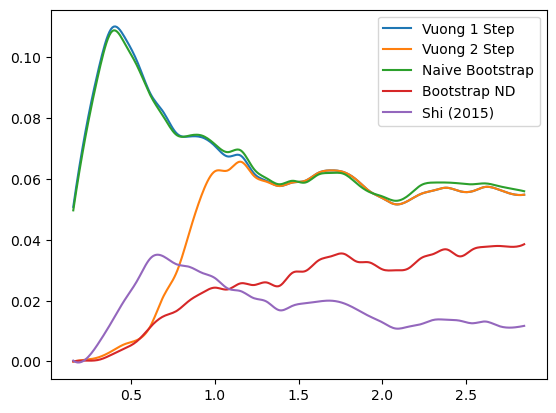

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs5/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs6/'+name,dpi=300)
    plt.show()



# Size stuff

In [4]:
nobs = 100
calc_c =lambda nobs: (nobs**(-1/4)/np.sqrt(nobs), (nobs+10)**(-1/3))
c1,c2 = calc_c(nobs)

def mc_run_size(nobs,c1,c2):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = 'size_nobs%s_c1%s_c2%s_nobs%s_trials%s.png'%(nobs,c1,c2,nobs,trials)
    create_fig(betas,results,name=name)
    
mc_run_size(nobs,c1,c2)

0.9696198967309502 -0.10310619001134166 4.53278791401043
-4.491689968883264 -0.10310619001134166 -0.9285219516037848
---
2.8049159042030487 -0.6296313046076548 6.652204235690894
-6.556611017166522 -0.6296313046076548 -2.7093226856786767
---
-0.6206724519280258 0.7445147311486078 3.280977001602055
-3.282305856604072 0.7445147311486078 0.6193435969260088
---
-0.33952549846042324 0.48987608039843344 3.423989958847304
-3.397411214566116 0.48987608039843344 0.36610424274161146
---
-0.9565502727519761 1.3951865219253472 2.810271337979477
-2.8199532895386175 1.3951865219253472 0.9468683211928356
---
-0.4727646130523615 0.41404279750621814 3.5632724946534293
-3.543203489611401 0.41404279750621814 0.4928336180943899
---
-0.21931068420090682 0.44463475270979874 3.5248616408036906
-3.3819688356475566 0.44463475270979874 0.362203489357041
---
-0.7526361266903526 0.6084427381803073 3.299098746041811
-3.3706764332342805 0.6084427381803073 0.681058439497883
---
4.915884116425159 -0.9584249142136134 8

0.625916212179841 -0.26502549331831216 4.478820142572393
-4.42418794745204 -0.26502549331831216 -0.571284017059489
---
2.256883489900309 -1.3260640846465561 6.3542171150529985
-6.34235831200268 -1.3260640846465561 -2.2450246868499897
---
0.8628899934011057 -0.23306846670074186 4.746021711256045
-4.764016840164796 -0.23306846670074186 -0.8808851223098573
---
0.8336328581520869 -0.673632995484004 4.585730673321428
-4.468629153929732 -0.673632995484004 -0.7165313387603902
---
-0.564220612714 0.48358552016997997 3.2880789606619385
-3.239223778454653 0.48358552016997997 0.6130757949212848
---
6.734299148748706 -2.2328144104705245 10.70768867071812
-10.693312356700483 -2.2328144104705245 -6.7199228347310695
---
3.902444240712086 -2.2582155803031685 7.569407940285919
-7.6527358129227965 -2.2582155803031685 -3.985772113348963
---
16.401553148077262 -4.575318865827427 20.153004928756232
-20.126746164030777 -4.575318865827427 -16.375294383351807
---
0.44708270380992454 -0.36353094308763556 4.473

-0.30727069289703357 0.11629173589138188 3.7198350184077884
-3.6195132983864062 0.11629173589138188 0.4075924129184155
---
2.564468990187491 -2.1315546991394054 6.463587715716159
-6.595726820183236 -2.1315546991394054 -2.6966080946545685
---
-1.0684741893056195 0.7533140721946686 2.7970042549888543
-2.8096897069685305 0.7533140721946686 1.0557887373259436
---
0.3076923076923077 [1. 0. 0.]
-0.9145117097661117 0.3875893281798814 2.907218673364154
-3.016940526409996 0.3875893281798814 0.8047898567202697
---
-0.5125767960093609 -0.2006286999741202 3.5012763231837614
-3.493757590139589 -0.2006286999741202 0.520095529053533
---
-1.273341567526573 1.2643115003130923 2.634790344291027
-2.621059378328591 1.2643115003130923 1.2870725334890087
---
-0.46849216267991584 -0.08627627783550268 3.403812564115832
-3.416928362994531 -0.08627627783550268 0.4553763638012178
---
-0.6606878197566867 0.1373840818227339 3.238932362111227
-3.2688102728619923 0.1373840818227339 0.630809909005921
---
-0.816646858

-0.27276139331038946 -2.1926655217242934 3.6278180053141247
-3.6095610007737933 -2.1926655217242934 0.2910183978507212
---
0.7198488811747527 -2.431822376734002 4.559209283508034
-4.5625458325821775 -2.431822376734002 -0.7231854302488964
---
-1.3981755291540412 2.199095998959897 2.1623681007164612
-2.3637930209266886 2.199095998959897 1.1967506089438138
---
0.3223466522361167 -2.554117955142829 4.178248140473905
-4.271400507620823 -2.554117955142829 -0.41549901938303413
---
-1.0028335299068722 -0.14518913560596322 3.037492036401989
-2.899405793583626 -0.14518913560596322 1.1409197727252347
---
0.020075655321600255 -2.0492516617671264 3.861889608644739
-3.9084671881738378 -2.0492516617671264 -0.06665323485069903
---
-0.35349943298522357 -0.8148907652822871 3.3827193435869183
-3.3429656831452013 -0.8148907652822871 0.39325309342694015
---
-0.8699117181255095 -0.5124936180602859 3.031775892725666
-2.9693146689357808 -0.5124936180602859 0.9323729419153943
---
-0.5955654084581506 -0.8139814

-0.8837857327933581 -2.1347081439497404 3.2292460921952637
-3.344295856080292 -2.1347081439497404 0.7687359689083301
---
-0.9322635268393541 -0.6028912980275982 2.986846096342082
-2.9469331615115895 -0.6028912980275982 0.9721764616698466
---
-1.1331358680961263 -0.508589754471893 2.808414550219178
-2.856641864029155 -0.508589754471893 1.0849085542861496
---
-1.0446509793449519 -0.4760696318621691 2.8504923369979065
-2.771850824230847 -0.4760696318621691 1.123292492112012
---
-0.7065840384814858 -1.9139831635089668 3.166952003619257
-3.138557082932277 -1.9139831635089668 0.7349789591684657
---
-1.2663569361110034 0.3634417883465172 2.4886256353259584
-2.5195675170433893 0.3634417883465172 1.2354150543935725
---
-1.0024354295822204 -0.527123405514171 2.975762828908037
-3.0199813644870708 -0.527123405514171 0.9582168940031865
---
-1.4421537405769371 0.49470215091293285 2.3864807555923013
-2.6134548565827713 0.49470215091293285 1.2151796395864678
---
0.6923076923076923 [0.98714286 0.001428

-1.3598711771361034 -0.48613870592036534 2.5670526161815546
-2.5543589083649305 -0.48613870592036534 1.3725648849527274
---
-1.3551770176737237 -0.3581269726176151 2.372088749508027
-2.647828449876575 -0.3581269726176151 1.0794373173051752
---
-1.4830751620545959 1.6027535839828666 2.4766471426787064
-2.289929716345469 1.6027535839828666 1.6697925883878333
---
-1.4447496261454678 1.6770004405438212 2.5039283388525004
-2.2389037543233594 1.6770004405438212 1.7097742106746086
---
-1.5610738681678615 0.42185747674785 2.438024716450177
-2.538694350169764 0.42185747674785 1.4604042344482748
---
-1.2848476400101827 -0.71951712222634 2.697634491764129
-2.6854408989637735 -0.71951712222634 1.2970412328105378
---
-1.1543740120502064 -0.6203937527854965 2.6327355810798214
-2.5361515464730036 -0.6203937527854965 1.2509580466570245
---
-1.4701989253043042 0.36387298818097885 2.2986101634645792
-2.547536882340035 0.36387298818097885 1.2212722064288482
---
-1.4769319386708895 1.2090164251909719 2.25

-1.4418969005259552 -0.49200039502800313 2.395483882152614
-2.4236460641337394 -0.49200039502800313 1.4137347185448295
---
-0.8926849642504828 -4.1385252001384325 3.0264630240584673
-2.9631308960710085 -4.1385252001384325 0.9560170922379421
---
-1.3475144313670622 -2.1674390482180033 2.8466953895927976
-2.7726805517373716 -2.1674390482180033 1.421529269222488
---
-1.4900790451593 0.09502566006680624 2.239561932723286
-2.4084312227659366 0.09502566006680624 1.3212097551166495
---
-1.5281465507120078 0.7466366889636037 2.464284244356644
-2.4397247882886735 0.7466366889636037 1.552706006779978
---
-1.2818563248913595 -1.1658676791930174 2.4858109830969766
-2.480723124481134 -1.1658676791930174 1.2869441835072022
---
-1.284614387533016 -1.0515652743529693 2.6136266047243493
-2.511773924437673 -1.0515652743529693 1.386467067819693
---
-1.3565504119871965 -1.249335184988007 2.542415159519308
-2.6061164896679365 -1.249335184988007 1.2928490818385685
---
-1.507014401655662 1.864854991894723 2.

1.2307692307692308 [0.98428571 0.00285714 0.01285714]
-1.612310233804961 0.18690711527308915 2.307315752603877
-2.451940070949181 0.18690711527308915 1.4676859154596569
---
-1.77070255060217 1.692495595919659 2.1930909980240183
-2.3789048994358364 1.692495595919659 1.5848886491903524
---
-1.4028481338919532 -1.4003996787386592 2.476686077218822
-2.4859656113473667 -1.4003996787386592 1.3935685997634082
---
-1.626016425302365 0.18484858714679886 2.3443837776340404
-2.44301365406237 0.18484858714679886 1.5273865488740352
---
-1.6106388659862971 0.2066816477552485 2.494641878823989
-2.4713586719530434 0.2066816477552485 1.6339220728572428
---
-1.3544996940231222 -2.1884194432659636 2.5399552330052435
-2.5594851228126085 -2.1884194432659636 1.3349698042157572
---
-1.7967537435768473 1.4442706408014108 2.2276259098672586
-2.44243902851925 1.4442706408014108 1.581940624924856
---
-1.4199363271368342 0.6545367130569615 2.1843718654588256
-2.2355226817918155 0.6545367130569615 1.36878551080384

-1.6553560677717183 1.2203349717582752 2.2655460714208697
-2.3380121733929897 1.2203349717582752 1.582889965799598
---
-1.497530258630658 -0.9424851325544077 2.449368028808253
-2.2944432552026006 -0.9424851325544077 1.65245503223631
---
-1.46990829328136 0.18949909969540554 2.3045367033427167
-2.197398380312366 0.18949909969540554 1.577046616311711
---
-1.4947679350984988 0.09982937958199246 2.367439632267964
-2.2123296307850366 0.09982937958199246 1.6498779365814262
---
-1.478900699164633 -0.05321409999213613 2.334531657451107
-2.2554670494443414 -0.05321409999213613 1.557965307171399
---
-1.5487065524885992 -1.4016309492200323 2.420405067175211
-2.475214180675342 -1.4016309492200323 1.493897438988468
---
-1.7125679670488931 0.4036666623380157 2.2335915788013385
-2.391032937223609 0.4036666623380157 1.5551266086266227
---
-1.570957614557045 0.3105271047187565 2.388121814511083
-2.277527443661632 0.3105271047187565 1.6815519854064964
---
-1.3975171511626905 -2.655534382887293 2.5193449

-1.6416104326256031 0.8672265426856055 2.320753502922276
-2.197754075159336 0.8672265426856055 1.7646098603885434
---
-1.7074254691725053 -0.32614455750336135 2.2003196347485288
-2.412995930335698 -0.32614455750336135 1.494749173585336
---
-1.6321755435287806 -0.836786500253641 2.294099856908019
-2.3370486861689255 -0.836786500253641 1.589226714267874
---
-1.646862480257281 1.7450264364230867 2.147985112086418
-2.1687997250342965 1.7450264364230867 1.6260478673094023
---
-1.8102318089461296 1.4053021735866327 2.1451629123589844
-2.3866717704652283 1.4053021735866327 1.5687229508398854
---
1.6153846153846154 [0.96285714 0.00571429 0.03142857]
-1.6889637524025312 -0.02589506891526737 2.171613985743617
-2.3756572747546802 -0.02589506891526737 1.4849204633914683
---
-1.7760701672422443 0.3643807259448741 2.208521562529012
-2.3542341122475103 0.3643807259448741 1.6303576175237458
---
-1.6912862134849591 -1.0453846425683646 2.2470359638286754
-2.391716551214537 -1.0453846425683646 1.54660562

-1.7328409472606814 -0.9212976928237536 2.154959013332696
-2.4264371737114887 -0.9212976928237536 1.461362786881889
---
-1.7058332066516622 -0.38766997701830047 2.3846405357990825
-2.3526791520728985 -0.38766997701830047 1.7377945903778462
---
-1.8020339403717962 0.6483693462769513 2.1109388567182985
-2.3608955235454507 0.6483693462769513 1.5520772735446442
---
-1.615295861392157 -0.12507743524605874 2.251505336663448
-2.2297927640668886 -0.12507743524605874 1.6370084339887165
---
-1.746932025773393 0.944242195771155 2.3092879726845994
-2.24932899642897 0.944242195771155 1.806891002029022
---
-1.6412828239861175 -0.5386374751186884 2.3362930088859555
-2.2737208840091294 -0.5386374751186884 1.7038549488629435
---
-1.6525633264496418 -0.6481754479621081 2.3605152484246417
-2.3269348998399937 -0.6481754479621081 1.6861436750342897
---
-1.7009563808557076 0.7934203269044439 2.3565954798498367
-2.267682668432344 0.7934203269044439 1.7898691922732002
---
-1.7183451322952503 0.953145313518676

-1.7067792082779427 -0.2704953789013726 2.3706616064591284
-2.248562199991103 -0.2704953789013726 1.828878614745968
---
-1.6283018063668722 -0.6430262700822013 2.143141493004979
-2.2081693417627504 -0.6430262700822013 1.563273957609101
---
-1.692490119106836 -0.1832639053091119 2.2751922378743377
-2.251439369224213 -0.1832639053091119 1.7162429877569616
---
-1.6763808283325492 -1.4001399772691387 2.278647540317806
-2.3176214263241075 -1.4001399772691387 1.637406942326248
---
-1.728504261869183 -0.2832443075545379 2.320234676681887
-2.2616228444787234 -0.2832443075545379 1.7871160940723465
---
-1.7421514295421745 0.7865458645747221 2.1012591860802785
-2.2781532542397325 0.7865458645747221 1.565257361382721
---
-1.8534494789202614 0.0337048975765133 2.2399962199801733
-2.3943431271985482 0.0337048975765133 1.6991025717018864
---
-1.6109868842472133 1.8461373566573018 2.127404334489581
-2.0814909061937628 1.8461373566573018 1.656900312543031
---
-1.8310210978754666 -0.8526410659978414 2.2

-1.6466158266273663 -0.3510461599765553 2.2838761799698597
-2.1707720152181764 -0.3510461599765553 1.7597199913790493
---
-1.4611948980784655 -2.111789198876601 2.199520363693866
-2.065643935011688 -2.111789198876601 1.5950713267606433
---
-1.8545790421332253 0.9516505157157675 2.350601695443578
-2.308412144931756 0.9516505157157675 1.8967685926450473
---
-1.8076817944988035 0.6271461710975869 2.321334196245497
-2.253969989852065 0.6271461710975869 1.8750460008922352
---
-1.8249092857828741 0.4493128091071735 2.100060542585241
-2.3024375043217646 0.4493128091071735 1.6225323240463505
---
-1.6920969190408872 -1.3387912636340846 2.2322591201068653
-2.2465593308240766 -1.3387912636340846 1.6777967083236756
---
-1.7116620339700115 0.08231464577173286 2.2172976372329956
-2.2031302732428326 0.08231464577173286 1.7258293979601746
---
-1.7056035900475164 -0.1719414319410358 2.3214429899897597
-2.1794776945984418 -0.1719414319410358 1.8475688854388344
---
-1.5368850578491153 0.16664603903916753

-1.772246797988954 -0.8147728803190131 2.1232859008428124
-2.278154568376337 -0.8147728803190131 1.6173781304554302
---
-1.6907329837939014 0.00929930564925907 2.2362194746522817
-2.145207950849446 0.00929930564925907 1.7817445075967369
---
-1.7685846144769772 -1.6548747661150347 2.096358507512003
-2.250948360619111 -1.6548747661150347 1.613994761369869
---
-1.8712303415646065 2.257824365792086 2.225050134238059
-2.2442887820106314 2.257824365792086 1.851991693792034
---
-1.8141129875913038 -0.45641448982449134 2.2136886162873566
-2.2852366481052018 -0.45641448982449134 1.7425649557734582
---
-1.5847491813126036 -2.0062084855107707 2.34679906472149
-2.1277083051515877 -2.0062084855107707 1.8038399408825054
---
-1.683421507795372 -1.9059657820802482 2.2972712962166892
-2.2443065384136074 -1.9059657820802482 1.736386265598454
---
-1.7742713071256462 0.19020345135528732 2.1127803101124947
-2.22279056717363 0.19020345135528732 1.6642610500645105
---
-1.689990713286469 0.9467648982961006 2.

-1.9494663750715335 -0.15398947343414812 2.283252612105489
-2.3898102148928815 -0.15398947343414812 1.842908772284141
---
2.5384615384615388 [0.96285714 0.00714286 0.03      ]
-1.9034161093106128 1.3798496618706253 2.106986021742631
-2.285796813378766 1.3798496618706253 1.7246053176744773
---
-1.6941833277174891 0.910359167688149 2.1499861776546294
-2.119599021290164 0.910359167688149 1.7245704840819547
---
-1.8056814803996264 0.03690120602419309 2.145188903238633
-2.2301137537150777 0.03690120602419309 1.7207566299231818
---
-1.8699948563988646 0.2910232429105762 2.2909590625039353
-2.2567730359513383 0.2910232429105762 1.9041808829514615
---
-1.6203269085728769 -1.121161774126982 2.0738721628288808
-2.0866732081896617 -1.121161774126982 1.6075258632120961
---
-1.8285152417325552 0.5870718381517186 2.2779043803701975
-2.200072964077081 0.5870718381517186 1.9063466580256718
---
-1.8288185682894957 0.12562991146366254 2.1250020008597903
-2.2443049390078564 0.12562991146366254 1.70951563

-1.7352309691374188 0.09818845287261925 2.1381214409814917
-2.1285361033138392 0.09818845287261925 1.7448163068050708
---
-1.7304684624881725 0.555955482753972 2.147732945515784
-2.122940606758948 0.555955482753972 1.7552608012450082
---
-1.844947654913153 0.439202149319786 2.2543845459211327
-2.2303863481280306 0.439202149319786 1.8689458527062548
---
-1.8576708380921287 2.1804441384675073 1.9802091039789995
-2.1642439243570863 2.1804441384675073 1.673636017714042
---
-1.8819744976031263 -0.15201699036319766 2.2167575227865357
-2.280129889165682 -0.15201699036319766 1.81860213122398
---
-1.7211620112780948 -0.8108820710904018 2.1504373420410894
-2.1284518513319544 -0.8108820710904018 1.74314750198723
---
-1.8727798670365274 0.025386406055818277 2.2303134952985895
-2.2689769545470764 0.025386406055818277 1.8341164077880405
---
-1.7647106581615146 -1.4154268022349077 2.1853082725587902
-2.2038315837710027 -1.4154268022349077 1.7461873469493026
---
-1.738280927848768 0.4994153380733702 2

-1.7919450968304835 0.1540514502555944 2.063125873366044
-2.1755518834747716 0.1540514502555944 1.679519086721756
---
-1.7179262179924615 -1.5919782886121014 2.1458774255730746
-2.1358958355998485 -1.5919782886121014 1.7279078079656875
---
-1.7002619799706489 -0.3596411292765114 2.2066324900834298
-2.0870811154792572 -0.3596411292765114 1.819813354574822
---
-1.796847836115141 1.6475108955048037 2.199606453118139
-2.1522753723232158 1.6475108955048037 1.8441789169100644
---
-1.7515066509518928 -0.06333624334227721 2.3087195170198624
-2.140688748159322 -0.06333624334227721 1.9195374198124329
---
2.9230769230769234 [0.96428571 0.01142857 0.02428571]
-1.8019514614850525 0.7938641415429422 2.213858046650016
-2.1477449581110393 0.7938641415429422 1.8680645500240292
---
-1.6824353639306588 -2.067431155054147 2.1092253950718947
-2.113082726655901 -2.067431155054147 1.6785780323466526
---
-1.874308725199966 -0.3689230652432314 2.165872314630724
-2.2554586062774233 -0.3689230652432314 1.7847224

# Power stuff

3.911049195420398 -4.150201114668454 7.987267128654615
-8.225202953999343 -4.150201114668454 -4.148985020765126
---
-0.6776828072557326 -0.1974302464901365 3.071081588074823
-3.0405283336531013 -0.1974302464901365 0.7082360616774543
---
-0.45154037751226345 -0.5728670275148074 3.6491077082792507
-3.5384306937425243 -0.5728670275148074 0.5622173920489898
---
-1.3712103451341175 0.07960156360233607 2.457460535376964
-2.6282207809196216 0.07960156360233607 1.20045009959146
---
-1.1318082284457414 -0.09101360871565932 3.0920585267138136
-2.8372318374793672 -0.09101360871565932 1.3866349176801878
---
-1.3148324304993164 0.4252697558459464 2.561242001320813
-2.4281574545711533 0.4252697558459464 1.4479169772489762
---
0.8932850040252006 -1.051925997235612 4.7963797148428196
-4.8868000051538285 -1.051925997235612 -0.9837052943362089
---
-1.052181504581107 -0.009199928880255006 2.8869330520162957
-2.8029825275484557 -0.009199928880255006 1.1361320290489474
---
-0.8336732195077154 -0.2318508421

0.08651070760696797 -1.072957684319911 3.9629495547964826
-4.123119050092858 -1.072957684319911 -0.24668020290334267
---
-0.04669173507558975 -1.5418247607009037 3.6957882629096415
-3.901413632126374 -1.5418247607009037 -0.15893363414114295
---
0.792129844856815 -1.4537088900953952 4.765335977419986
-4.770952897983793 -1.4537088900953952 -0.7977467654206223
---
2.724160434651704 -2.976643864794731 6.539825318624444
-6.9472889813962215 -2.976643864794731 -3.1316240974234826
---
2.8830354937269083 -3.552294831001614 6.673215964190673
-6.865732649405751 -3.552294831001614 -3.075552178941987
---
-0.02577247810476369 -1.058511507375434 4.1239340484632105
-4.260290495035581 -1.058511507375434 -0.11058396846760624
---
0.8286225678867285 -1.9552192659748073 4.791315408028054
-4.877689198782028 -1.9552192659748073 -0.9149963586407025
---
-0.6256845986935413 -0.24386810048852178 3.1348259056060512
-3.001539109576699 -0.24386810048852178 0.7589713947228939
---
1.8051420759964778 -2.52199722605290

-1.0809653823655732 -0.20268877551960532 2.693941414785378
-2.643589953644339 -0.20268877551960532 1.1313168435066117
---
5.264240628428495 -3.7802093093030464 8.970446823522895
-8.868091950077059 -3.7802093093030464 -5.1618857549826584
---
2.9974844419594064 -5.133276522982826 6.931782432030965
-6.939749597232254 -5.133276522982826 -3.0054516071606954
---
-1.2172151972315814 0.12824078887904716 2.691356223055336
-2.8136957750729454 0.12824078887904716 1.0948756452139727
---
-1.4581248268612363 0.9384755809280835 2.301403862164991
-2.158288130337735 0.9384755809280835 1.6012405586884921
---
-0.6526484132818138 -0.5996411170976321 3.189308257745186
-3.1791504604098377 -0.5996411170976321 0.6628062106171617
---
-1.3952547781198317 -0.16719387464505625 2.59711374945535
-2.67484406026091 -0.16719387464505625 1.3175244673142719
---
-0.9766698543306087 -0.3171205402882346 2.8193211827242446
-2.8506966516100127 -0.3171205402882346 0.9452943854448406
---
-1.2486925986247475 0.0952474036956405 

-1.6461654774594825 0.9326811749252026 2.2820259777304495
-2.2851866640952205 0.9326811749252026 1.6430047910947114
---
-0.3959932239797359 -1.6752397216019763 3.4296956396373774
-3.6272229115276517 -1.6752397216019763 0.19846595208946174
---
-1.3122156029010852 -0.17971267205590266 2.661398247125601
-2.4108708685043596 -0.17971267205590266 1.5627429815223264
---
-0.5581224198603175 -1.5063749267285707 3.2804912325352724
-3.267980977038712 -1.5063749267285707 0.570632675356878
---
-1.325638783506779 -0.3187822638512992 2.6232034569938123
-2.8390392349324927 -0.3187822638512992 1.109803005568099
---
-1.4509059480406097 0.14337664254343338 2.2546388065012763
-2.4728003606826756 0.14337664254343338 1.2327443938592106
---
-1.158104230171754 -1.275836601572331 2.9696163581417347
-3.1504619138337726 -1.275836601572331 0.9772586744797163
---
-1.1210356373885373 -0.9132673215592603 2.893819790234732
-3.1350205946798693 -0.9132673215592603 0.8798348329434
---
-1.3519018770718996 0.1870175667253

0.12071628924549702 -4.700389813558531 4.39449437525171
-4.59570850694284 -4.700389813558531 -0.3219304209366265
---
-1.014261443353162 -1.0517751795247707 2.884584210018451
-2.8003211852884236 -1.0517751795247707 1.0985244680831892
---
-1.287795204956059 -0.6150153570082345 2.5255943763074926
-2.5108857988609588 -0.6150153570082345 1.302503782402593
---
-1.0197284898391648 -1.4516854802805899 2.8606235644188343
-2.90313968424646 -1.4516854802805899 0.9772123700115387
---
-1.4939457324888965 -0.2548397773649336 2.511242184389126
-2.5080874431881774 -0.2548397773649336 1.4971004736898448
---
-1.3277969391367017 -0.3669490170765258 2.6006788770429448
-2.5387190103651096 -0.3669490170765258 1.3897568058145373
---
-1.098826642943631 -1.9515853070224431 2.9454155876584567
-3.1563617177551335 -1.9515853070224431 0.8878805128469545
---
-1.462494730320447 -0.09550296271631914 2.6295710660714136
-2.5149393728717673 -0.09550296271631914 1.5771264235200935
---
-1.2217623734727123 -1.5735878394463

-0.9550907283552001 -2.054219840923592 3.151008293200321
-3.3329171826968733 -2.054219840923592 0.7731818388586479
---
-0.4947646610272954 -2.7433941098327477 3.48849028526611
-3.642990949126198 -2.7433941098327477 0.3402639971672079
---
-0.525164888269959 -5.305756962906293 4.016081026231528
-4.6148580100618375 -5.305756962906293 -0.07361209556035092
---
-0.6615512978308269 -3.035148737587625 3.1135114902444774
-3.1674935232171597 -3.035148737587625 0.6075692648581442
---
-0.6460935672262124 -3.0794342491202253 3.0186283412602166
-3.0075505801264093 -3.0794342491202253 0.6571713283600193
---
-1.4515887709189599 -0.7031236283559434 2.4752354499733196
-2.5656162422665165 -0.7031236283559434 1.361207978625763
---
-1.4006775409733043 -1.7154239217430363 2.6259313602589556
-2.799886427302637 -1.7154239217430363 1.2267224739296227
---
-0.20333317352965102 -3.6486600956766417 3.796362891792206
-3.8335408233984545 -3.6486600956766417 0.1661552419234026
---
-1.6460290985826878 0.67436847109667

-0.28302467203416243 -5.9145047032267275 3.5651599946423307
-3.85183407115078 -5.9145047032267275 -0.003649404474287206
---
-0.531344068441149 -5.279170921746634 3.8389239969657214
-4.453705628453605 -5.279170921746634 -0.08343756304673407
---
-0.8382071618986389 -3.8459879110008637 3.1753182639782542
-3.196437751912194 -3.8459879110008637 0.8170876739646994
---
-0.9316881544315809 -3.9092771531790085 3.301976903803383
-3.4678276268298225 -3.9092771531790085 0.7658374314051413
---
-1.2306707973122928 -2.809174001823647 3.088657328444596
-3.30382105624556 -2.809174001823647 1.0155070695113284
---
-0.3191290119737293 -3.5679527075185993 3.7186237624419527
-3.7755906679868088 -3.5679527075185993 0.26216210642887344
---
-0.5451822941145463 -5.590368533318932 3.3541574505605154
-3.6982385841109386 -5.590368533318932 0.20110116056412353
---
-1.4521744011991247 -1.6132435148831163 2.5971530526143733
-2.7110815697259554 -1.6132435148831163 1.338245884087543
---
-0.7873068509899855 -5.982693952

-0.8261614641114278 -7.413788146022564 3.9029894910550347
-4.338350299257441 -7.413788146022564 0.3908006559090214
---
-1.0337373076728364 -7.320728937945931 3.4922959819706128
-4.12626912566465 -7.320728937945931 0.3997641639787991
---
-1.22234812879674 -5.747617739496263 2.845312693517198
-3.1004721924179126 -5.747617739496263 0.9671886298960254
---
-1.0229178072756975 -5.296098953662966 3.174809049113434
-3.529638012103576 -5.296098953662966 0.6680888442855555
---
-1.821427282675598 -1.3278810035019475 2.34563413423199
-2.6109279470333564 -1.3278810035019475 1.5561334698742317
---
-1.4611325779815594 -2.10988986124435 2.549283091139629
-2.741695916604716 -2.10988986124435 1.2687197525164724
---
-1.0797835607043065 -7.226003747078532 3.2486832357460638
-3.5056980761736347 -7.226003747078532 0.8227687202767356
---
-0.8829985445789603 -6.040258530765383 3.3011114164955795
-3.632105669170169 -6.040258530765383 0.5520042919043706
---
-1.386298070263046 -0.9085800626461636 2.2046925281324

-1.420525222984548 -7.848003162606667 3.3896363388757855
-3.963004793046846 -7.848003162606667 0.8471567688134873
---
-0.791898025017378 -7.191810877593561 3.3239534614635673
-3.3775730371059405 -7.191810877593561 0.7382784493750049
---
-1.4762568909050435 -2.4999727138318733 2.531462731577155
-2.706288151862799 -2.4999727138318733 1.3014314706194
---
-1.3751364633855263 -6.060342280426927 3.2385055105247798
-3.6277464490694906 -6.060342280426927 0.9858955248408156
---
-1.2132080945444734 -3.6475712030904965 2.892601564147063
-3.004418506229798 -3.6475712030904965 1.1013911524617386
---
-0.8105885205163553 -7.613926934215031 3.4062437999959507
-3.7255909231755795 -7.613926934215031 0.4912413973367264
---
-0.9169780871786793 -6.019731601291401 2.912606609752508
-3.1234534995197314 -6.019731601291401 0.7061311974114557
---
-1.649201380732227 -3.752502567396946 2.7204111327380054
-2.9670832845331527 -3.752502567396946 1.4025292289370797
---
-1.7936184617674955 -6.806260641410057 3.0624882

-1.4171459821930816 -6.829015015188502 3.0330302229423842
-3.238517927018464 -6.829015015188502 1.2116582781170016
---
-2.0379042985877205 -3.666509900738757 2.566169048121995
-3.1083824116903522 -3.666509900738757 1.4956909350193632
---
-1.4901544295928646 -4.370807570232247 2.623349860023235
-2.812133640051591 -4.370807570232247 1.3013706495645085
---
-1.7180995805069006 -8.292363770888857 3.363628163149625
-3.8504195181815897 -8.292363770888857 1.2313082254749361
---
-1.4621785038596984 -6.556167529431922 2.784801119054298
-3.2039620047183046 -6.556167529431922 1.0430176181956918
---
-1.5370108083953438 -9.544792040460589 3.156966314084839
-3.465039088716754 -9.544792040460589 1.228938033763429
---
-1.323556063783954 -5.976774194433644 2.732384280935805
-3.0505056950797353 -5.976774194433644 1.0054346496400233
---
-1.3444641155213128 -8.399848241305087 2.8430489930277267
-3.307136085764971 -8.399848241305087 0.8803770227840687
---
-1.4684554840145845 -4.0099585402836455 2.4735308722

-1.4044667496302419 -8.208257827114565 3.1749954415036448
-3.578621516395666 -8.208257827114565 1.000840674738221
---
-1.48852455156537 -6.643332002999499 2.7569010312121214
-3.112850223085854 -6.643332002999499 1.1325753596916373
---
-1.6010340660275688 -8.847067966097793 3.06327359939113
-3.4473887440398134 -8.847067966097793 1.2169189213788858
---
-1.7145863656067708 -8.032590612854527 2.8605608512180214
-3.2917980894890913 -8.032590612854527 1.283349127335701
---
-1.3978003264340046 -10.974015545934435 3.420748534072196
-3.8197541873942997 -10.974015545934435 0.9987946731119007
---
-1.6495161706969652 -4.583034949656241 2.4492249145333345
-2.715015812035634 -4.583034949656241 1.3837252731946657
---
-1.2936714047196007 -9.619814722611268 3.1340311107258483
-3.4128544956019473 -9.619814722611268 1.0148480198435017
---
-1.4046913665925842 -8.531219153806353 2.932722771841454
-3.424972062007826 -8.531219153806353 0.9124420764262121
---
-2.5285296704185267 -7.866856296596407 3.310654544

-2.0168638765385647 -8.533475795942003 2.8521774957596353
-3.3678899221152387 -8.533475795942003 1.501151450182961
---
-1.949377777581543 -6.120439067817871 2.7182543334209326
-3.1649711759096526 -6.120439067817871 1.5026609350928233
---
-1.6286594290604632 -4.929281861137798 2.5244697486084573
-2.503817062639435 -4.929281861137798 1.6493121150294852
---
-1.7902459870553065 -7.5684725772781 2.862722294329761
-3.180036753667257 -7.5684725772781 1.4729315277178106
---
-1.7722868957896085 -9.179202126674872 3.0991985766810672
-3.508420236562905 -9.179202126674872 1.363065235907771
---
-1.6872514750959486 -11.107311547838078 3.243779966363985
-3.710712129369091 -11.107311547838078 1.2203193120908427
---
-1.7692705146557586 -7.715325567024356 2.8503637934829023
-3.1462598528381545 -7.715325567024356 1.4733744553005066
---
-1.7221327950002714 -6.299427784838193 2.7199655929864437
-2.8138038535338654 -6.299427784838193 1.6282945344528499
---
-1.9984095354370213 -5.04583678637568 2.49812410066

-1.8038245034339548 -11.149173669832443 3.024712506345713
-3.570495778086347 -11.149173669832443 1.258041231693321
---
-1.855187441899942 -10.043477093320535 3.068074289770733
-3.4815904422222017 -10.043477093320535 1.4416712894484736
---
-1.9266149762578713 -6.279671884727443 2.5330743535722595
-2.955881077184918 -6.279671884727443 1.5038082526452128
---
-2.288662125651095 -10.385364150766417 3.205223248939701
-3.9256539713088885 -10.385364150766417 1.5682314032819074
---
-1.7042209556576373 -4.902870139537104 2.4269497608527857
-2.680341509613155 -4.902870139537104 1.450829206897268
---
-1.6533676348793107 -8.841721634581239 2.7031942678270133
-3.1104444788150682 -8.841721634581239 1.246117423891256
---
-1.8566696023005194 -6.057145520498773 2.6787717016063137
-3.0674141739791443 -6.057145520498773 1.468027129927689
---
-2.3328512179628884 -8.099123384846582 2.88141529761737
-3.6352202128922606 -8.099123384846582 1.5790463026879977
---
-1.4716068009062346 -9.132916255870702 2.9259891

-2.260302842156133 -13.615349196373167 3.1804760621461465
-3.9721031187712508 -13.615349196373167 1.4686757855310288
---
-1.8035403395838125 -10.248962900794258 2.6425663384307465
-3.114530124502333 -10.248962900794258 1.3315765535122261
---
-1.798784759152366 -8.353966351266525 2.705992034054243
-3.0884626307252097 -8.353966351266525 1.4163141624813997
---
-2.540566645311484 -10.775037989911155 3.0318454704040394
-3.87239949872937 -10.775037989911155 1.7000126169861534
---
-1.8715960300491872 -6.213548640586412 2.5614420469903516
-2.7096760746717963 -6.213548640586412 1.7233620023677425
---
-1.7313292834835827 -10.800150944873751 2.886034575832094
-3.466877185642864 -10.800150944873751 1.150486673672813
---
-2.0668230916823096 -13.698815332534648 3.0764343430847445
-3.7843946906927273 -13.698815332534648 1.3588627440743268
---
-1.6470966749987803 -7.150458468508043 2.2982672958341253
-2.737859908639012 -7.150458468508043 1.207504062193894
---
-1.8422535904120085 -9.877815666116899 2.7

-1.8714997095008696 -7.034883856509936 2.5728689022545446
-2.816680231260544 -7.034883856509936 1.6276883804948703
---
-2.2267822484077 -9.478347148414658 2.6501316759317515
-3.1959338846685243 -9.478347148414658 1.6809800396709271
---
-2.1820590553115036 -9.85712852669763 2.658390306423756
-3.3274312317954866 -9.85712852669763 1.5130181299397727
---
-1.8302600770549116 -9.337778963068034 2.4573750272990886
-2.9462499039243766 -9.337778963068034 1.3413852004296234
---
-2.1127200797705057 -12.637195329995548 3.203744338429101
-3.4926374234709265 -12.637195329995548 1.8238269947286803
---
-2.006051913083972 -12.736007800607894 2.9669097539403984
-3.4934698198072875 -12.736007800607894 1.4794918472170824
---
-2.0670394259593494 -9.314969230820285 2.6537274118540943
-3.155868529499601 -9.314969230820285 1.564898308313843
---
-1.805312734833002 -11.394877586945592 2.69196044710306
-3.0921437782034045 -11.394877586945592 1.4051294037326574
---
-2.1167290099014444 -10.857095172744406 2.796010

-2.4906922548799892 -12.727579707166127 2.962044743307539
-3.89505595743731 -12.727579707166127 1.5576810407502186
---
-2.700010894225186 -12.867104539306807 3.592260723587169
-4.210791655598267 -12.867104539306807 2.0814799622140883
---
-2.0939063956322257 -7.763558249011927 2.464215509865069
-3.0418074688731074 -7.763558249011927 1.5163144366241872
---
-2.2516579272351196 -13.269612333626931 2.8026124471188916
-3.5600230849942918 -13.269612333626931 1.4942472893597192
---
-2.129800555312151 -6.6449043596539825 2.24085265098123
-2.835574831976666 -6.6449043596539825 1.535078374316715
---
-2.8387461407825225 -7.758975472724708 2.844271521899202
-3.698956372841319 -7.758975472724708 1.9840612898404053
---
-1.882988315796297 -12.032868375919797 2.787484422833277
-3.1250065937209204 -12.032868375919797 1.5454661449086537
---
-2.5214391157929046 -13.013502635720217 2.9355842507150336
-3.7617284290256143 -13.013502635720217 1.6952949374823236
---
-2.0536917895835427 -4.808440010266852 2.244

-2.298471709189227 -14.14425170852831 2.8385660320977446
-3.5203941395784795 -14.14425170852831 1.6166436017084922
---
-2.4071042328343695 -9.033420047591969 2.616420301790437
-3.316310438282017 -9.033420047591969 1.7072140963427895
---
-3.41636010312799 -12.615361868348657 3.362951151962057
-4.581012610055105 -12.615361868348657 2.1982986450349413
---
-2.0976163135155503 -8.811558535063979 2.3915293977229677
-2.9544404165422464 -8.811558535063979 1.5347052946962716
---
-1.9371473565819812 -10.884340591094766 2.4473473291627394
-2.9392041443942407 -10.884340591094766 1.4452905413504802
---
-2.3611567106462323 -13.797551927117297 2.892184944268972
-3.573627003463361 -13.797551927117297 1.6797146514518433
---
-2.307759922728716 -11.19591560225917 2.8931887976461876
-3.4348027467299764 -11.19591560225917 1.766145973644927
---
-2.0820463289088162 -16.212710710778246 3.1581097290681037
-3.553765390007723 -16.212710710778246 1.6863906679691971
---
-2.3046223307020477 -15.444862269009814 3.11

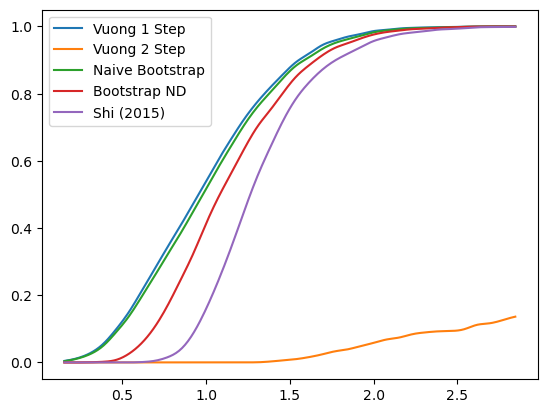

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs


nobs = 100
c1,c2 = calc_c(nobs)

def mc_run_power(nobs,c1,c2):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = 'power_nobs%s_c1%s_c2%s_nobs%s_trials%s.png'%(nobs,c1,c2,nobs,trials)
    create_fig(betas,results,name=name)
    
mc_run_power(nobs,c1,c2)

# extra size sims

1.3845834469001659 -0.9513224714892333 5.2271985404537205
-5.363473247783928 -0.9513224714892333 -1.5208581542303738
---
12.163791854975202 -4.041370090827243 15.65616659969242
-15.653409557095571 -4.041370090827243 -12.161034812378352
---
-0.760110813072698 0.19265708524173117 3.172079485540687
-3.2597854526904873 0.19265708524173117 0.6724048459228976
---
10.087732716019303 -3.4858181856597135 13.65713579829633
-13.884456553488477 -3.4858181856597135 -10.31505347121145
---
16.169922574702962 -5.132982144490867 19.600198527667853
-19.590118335264567 -5.132982144490867 -16.159842382299676
---
24.264722449657498 -9.424922248653608 27.614844471088247
-27.705661456414695 -9.424922248653608 -24.355539434983946
---
3.4146778241665157 -1.486529974195803 7.071459100673539
-7.204908577029979 -1.486529974195803 -3.548127300522956
---
2.3832741130930284 -1.201923883762164 6.108921049215117
-6.0633668442753095 -1.201923883762164 -2.337719908153221
---
1.6032972971524373 -0.9035631164591835 5.5373

0.8617903149914145 -0.814736277669431 4.73380060252525
-4.810400903348307 -0.814736277669431 -0.9383906158144717
---
8.076129057627636 -3.0871657309263805 11.835287676348429
-11.888186233485076 -3.0871657309263805 -8.129027614764283
---
6.099048779137774 -4.3073679360823345 9.902574861493216
-9.956688128869605 -4.3073679360823345 -6.153162046514164
---
-0.6800141210910252 0.20437443987511283 3.3170749479399606
-3.1754695917461913 0.20437443987511283 0.8216194772847943
---
0.9846875839808003 -0.9556594721973344 4.702795623865238
-4.95101160656715 -0.9556594721973344 -1.2329035666827115
---
-1.0639331925513877 0.6131136387118805 2.909652642236198
-2.8566140105830153 0.6131136387118805 1.1169718242045696
---
-1.144909554511549 0.5219630529559476 2.6105533646947516
-2.8487168944761767 0.5219630529559476 0.906746024730124
---
-0.029137956953755786 -0.6740844212778625 3.9115623245584445
-3.9081415333160754 -0.6740844212778625 0.032558748196125316
---
-0.8425409357292656 0.1172698547631676 3.

1.9795316339663782 -2.1064296079498437 5.799802085804496
-5.8807603154216865 -2.1064296079498437 -2.0604898635835682
---
7.395088632634024 -4.156066690530094 10.933867344064636
-11.35264996078834 -4.156066690530094 -7.813871249357731
---
4.497853135967417 -4.201582460124321 8.320402031681985
-8.394282947682806 -4.201582460124321 -4.571734051968238
---
[1. 0. 0.]
0.8760767765023841 -1.8527786841007612 4.730844715964722
-4.8167607043382095 -1.8527786841007612 -0.9619927648758716
---
-1.1161093724712938 0.24852447980391837 2.6688039160356567
-2.6292908186036907 0.24852447980391837 1.15562246990326
---
-0.6416628125413176 -0.5416985663864632 3.2341389104618696
-3.41732751327357 -0.5416985663864632 0.4584742097296169
---
-0.4898278218184834 -0.8274516024408507 3.342658475947483
-3.4393712566993817 -0.8274516024408507 0.3931150410665849
---
-0.8964953407620883 0.15693253146914116 2.860865196525506
-3.025530966660958 0.15693253146914116 0.7318295706266362
---
-0.15316033883149202 -1.209661005

-1.2838806060226928 -0.08790693343022306 2.7048554766291026
-2.869656021137779 -0.08790693343022306 1.1190800615140164
---
-0.9357354613484701 -0.4812880035745508 3.1415530244456717
-3.146600331231177 -0.4812880035745508 0.9306881545629652
---
-0.5062157366638722 -1.5144019674237914 3.543415156112283
-3.621303498679567 -1.5144019674237914 0.4283273940965885
---
-1.3453358513093878 0.6942078597435956 2.690095437002284
-2.530720395028629 0.6942078597435956 1.504710893283043
---
-1.2308049884189034 0.06203280075037687 2.667008093184646
-2.8923524279020754 0.06203280075037687 1.0054606537014734
---
-0.9966942997935566 -0.5047024730320391 2.8303708209093914
-2.8819089679360244 -0.5047024730320391 0.9451561527669233
---
-1.0088724188545382 -0.2900958044683782 2.83907222016863
-2.853795283438965 -0.2900958044683782 0.994149355584203
---
-0.4886986934067911 -1.0638205524350495 3.3445093259649363
-3.234874300370347 -1.0638205524350495 0.5983337190013801
---
-1.3155181161509792 0.539873979716112

-1.34871458721515 -0.06832539978177005 2.7510149660276233
-2.7787978087971306 -0.06832539978177005 1.3209317444456428
---
-1.1114061279530498 -0.925043521122776 2.958212757543615
-3.154092212041661 -0.925043521122776 0.9155266734550044
---
-1.3576351299353784 0.4985780162149913 2.438852888344898
-2.401785300280583 0.4985780162149913 1.394702717999693
---
-0.651114352305813 -1.399952727551111 3.1500507614256157
-3.2013370132572954 -1.399952727551111 0.5998281004741335
---
-0.9465830668614768 -1.1711236727194507 2.915524111218827
-2.9775231878985857 -1.1711236727194507 0.8845839901817184
---
-0.9728859658426294 -1.0018373824285305 2.9691759782339346
-3.156019774895585 -1.0018373824285305 0.7860421691809788
---
-1.2350274088801578 -0.5511098275575386 2.6699170572880524
-2.855135101565486 -0.5511098275575386 1.049809364602724
---
[0.95714286 0.         0.04285714]
-1.5217266596511545 0.8911770117155081 2.286126832093647
-2.348291234371964 0.8911770117155081 1.459562257372838
---
-1.5277953

-0.4787334271571905 -3.988528646193428 3.4089024076457934
-3.4360098518113107 -3.988528646193428 0.4516259829916735
---
0.4834292805907041 -6.3096956652407785 4.237407369367335
-4.257318389135889 -6.3096956652407785 -0.5033403003592575
---
-1.503086147961019 0.19242867708487435 2.503054187948725
-2.5108297764631637 0.19242867708487435 1.4953105594465808
---
-1.662056054257026 0.772344167200908 2.2938616028882413
-2.5034159163328438 0.772344167200908 1.4525017408124234
---
-1.1083062208545411 -0.7330428862140609 2.7557344002597675
-2.613282668720173 -0.7330428862140609 1.2507579523941355
---
-1.40934248206471 -0.2365256882354064 2.641973070141041
-2.5421711930935342 -0.2365256882354064 1.5091443591122167
---
-1.6017384732266395 1.3087020492744919 2.442006922995608
-2.379938206480951 1.3087020492744919 1.6638071897412965
---
-1.437704637062188 -0.033314059010207356 2.5246154745842326
-2.488697179171807 -0.033314059010207356 1.4736229324746133
---
-1.54596795782389 -0.7741806748855938 2.3

-1.4755618839037614 -0.39532168341166235 2.3851965979708
-2.424628496872324 -0.39532168341166235 1.4361299850022375
---
-1.507832436020626 0.460592889391188 2.265561154557192
-2.3239287173553236 0.460592889391188 1.4494648732224942
---
-1.5447891778841536 0.9061724637575033 2.328283465189898
-2.1441029808650436 0.9061724637575033 1.728969662209008
---
-1.5862275964500783 -0.012375665567587131 2.4307146483498383
-2.4140163146914704 -0.012375665567587131 1.6029259301084455
---
-1.5685118427507068 0.58682231553918 2.3782245024309896
-2.3740365569495685 0.58682231553918 1.5726997882321274
---
-1.5582893770632524 0.8007412639620919 2.279322040618951
-2.3257518992119457 0.8007412639620919 1.5118595184702581
---
-1.0495538063906031 -2.8655545310665187 2.930814632132821
-3.019930189111807 -2.8655545310665187 0.9604382494116172
---
-1.4566193167217076 0.3747892234749814 2.4036741159976884
-2.296114200020114 0.3747892234749814 1.564179232699282
---
-1.4391041788843149 0.49687907542430143 2.36717

-1.7105327196365903 1.0215924448426958 2.143607821254907
-2.2881451126595658 1.0215924448426958 1.5659954282319315
---
-1.550249200475934 0.6388271228034271 2.305422904328813
-2.200043948230285 0.6388271228034271 1.6556281565744624
---
-1.6134172691475646 -1.2439677087681846 2.3863588260981743
-2.463743129966007 -1.2439677087681846 1.536032965279732
---
-1.6037230435485907 1.2181190866236076 2.2238148980981656
-2.195501521611587 1.2181190866236076 1.6320364200351696
---
-1.4957165054118293 -0.713488991235179 2.374857465629405
-2.36325513260725 -0.713488991235179 1.507318838433984
---
-1.6703442568975293 -0.3573054816422145 2.380726586893743
-2.4995940102899556 -0.3573054816422145 1.5514768335013167
---
-1.8189249499931903 1.1304980500204653 2.2930089525131847
-2.383494054543473 1.1304980500204653 1.728439847962902
---
-1.7103510392555414 0.09177479947249784 2.284857661781176
-2.4439672681247293 0.09177479947249784 1.5512414329119877
---
-1.7378064194725416 0.02947348586811827 2.2825615

-1.6649598122212057 0.5805011862125578 2.2391155134292404
-2.233216530628639 0.5805011862125578 1.670858795021807
---
-1.594513314023349 0.8325044613515588 2.398593792452985
-2.1713253277471054 0.8325044613515588 1.8217817787292285
---
-1.6038136134018957 -0.0058456791468276805 2.3681105460387815
-2.2927795438085 -0.0058456791468276805 1.6791446156321768
---
-1.4756300693756985 -0.385601159189124 2.317615859520705
-2.1647975859071558 -0.385601159189124 1.6284483429892478
---
-1.6546357622556884 -0.09585828076781847 2.239576613143299
-2.279191744742346 -0.09585828076781847 1.6150206306566417
---
-1.5194703797951634 -0.8807211848752944 2.3458854133934937
-2.3084515058768647 -0.8807211848752944 1.5569042873117922
---
-1.5440901778174427 0.5299951939051903 2.4572276507445765
-2.1538916446683145 0.5299951939051903 1.8474261838937047
---
-1.6199494962298446 2.251024501178754 2.136242935628068
-2.0488111903770525 2.251024501178754 1.7073812414808605
---
-1.4062230117971484 -1.5309304702502666

-1.651669858452829 1.1726201396999243 2.3150952867318777
-2.1616210445475086 1.1726201396999243 1.8051441006371984
---
-1.6094130481677238 0.9597103509721695 2.201393106528264
-2.120422984315154 0.9597103509721695 1.6903831703808339
---
-1.7491730666318905 -1.26118359958195 2.1604896802030535
-2.5563048905798476 -1.26118359958195 1.3533578562550967
---
[0.97142857 0.00285714 0.02571429]
-1.7640601019879565 0.8966818446461079 2.354098254335082
-2.218100310539291 0.8966818446461079 1.9000580457837475
---
-1.6855890893472243 0.2614264877898819 2.24025703451338
-2.2391170734144117 0.2614264877898819 1.686729050446193
---
-1.7487959800747286 -0.4199223317143414 2.188026021239261
-2.3309209279852072 -0.4199223317143414 1.605901073328782
---
-1.80294896843062 0.6110865498358447 2.2757737099596387
-2.262609173217932 0.6110865498358447 1.8161135051723267
---
-1.7170870722316267 0.07141050550212637 2.1745065060350823
-2.245955321813726 0.07141050550212637 1.6456382564529835
---
-1.68816604749566

-1.7363475194469526 -0.8857613294043984 2.296722957264277
-2.3108454850578846 -0.8857613294043984 1.7222249916533456
---
-1.6143640550250125 0.2129897819618081 2.261235355368804
-2.1273269446241323 0.2129897819618081 1.748272465769684
---
-1.6924722794062823 -1.2941432339610524 2.3433575582213786
-2.3290981387404743 -1.2941432339610524 1.7067316988871868
---
-1.6588555075587765 -1.0763921617473369 2.3262588711199608
-2.311148062715192 -1.0763921617473369 1.673966315963545
---
-1.7694934101393318 -0.6051056199310291 2.2144332921168983
-2.3948608821790005 -0.6051056199310291 1.5890658200772296
---
-1.6215449658217995 0.2511238063332331 2.191464939767993
-2.122680068305998 0.2511238063332331 1.6903298372837952
---
-1.5962966031287873 -1.337251280314349 2.1713748706302427
-2.2650530542614447 -1.337251280314349 1.5026184194975858
---
-1.7437479634759887 0.5313709653843509 2.191035267256547
-2.266921372611549 0.5313709653843509 1.6678618581209868
---
-1.6307711764731807 0.019915292172181565 

-1.6237097445681974 -0.051145481992670626 2.271101896276841
-2.0921537165907065 -0.051145481992670626 1.802657924254332
---
-1.882787203769184 1.3389575297441807 2.292693414998468
-2.2905575483914147 1.3389575297441807 1.8849230703762374
---
-1.7156392403847676 0.15410730502126258 2.1911163694331828
-2.1589774455874284 0.15410730502126258 1.7477781642305221
---
-1.7213324206696619 -0.3942174814545996 2.1884045135805863
-2.242313369375288 -0.3942174814545996 1.6674235648749607
---
-1.6591579538058618 -0.45413031353831695 2.2419655772477505
-2.134265832344786 -0.45413031353831695 1.7668576987088258
---
-1.7004184829200066 1.1475819245998313 2.2479569842928786
-2.123733302558469 1.1475819245998313 1.824642164654416
---
-1.6865197428487497 1.6079365802394454 2.1286821305178876
-2.0826916817448575 1.6079365802394454 1.7325101916217795
---
[0.96428571 0.00428571 0.03142857]
-1.760368760829434 0.24944248674523187 2.176022669699298
-2.2054452241441043 0.24944248674523187 1.7309462063846275
---

-1.7211823786504739 -1.0461666381507404 2.1396674765902053
-2.2010188476067722 -1.0461666381507404 1.659831007633907
---
-1.7890894408195706 -0.08388351159132558 2.1137958026749453
-2.2259576448861655 -0.08388351159132558 1.6769275986083503
---
-1.8949064190850173 0.21894602336116106 2.2270533923282003
-2.314302999232066 0.21894602336116106 1.8076568121811518
---
-1.8043422065828718 0.33454142032646345 2.048141719884575
-2.191171953111692 0.33454142032646345 1.6613119733557546
---
-1.7895299691398827 1.2203811023121969 2.095011299495916
-2.1445692470410873 1.2203811023121969 1.739972021594711
---
-1.6893682976928583 0.40642146029902837 2.2001925250484415
-2.1380849245340987 0.40642146029902837 1.7514758982072014
---
-1.9167626732134055 -0.13104246682330534 2.169136921439786
-2.3230193283317497 -0.13104246682330534 1.7628802663214418
---
-1.650252626042571 -1.0305749065443572 2.3933518831232
-2.156709307668234 -1.0305749065443572 1.886895201497537
---
-1.6543190045672669 0.6726500606048

-1.6594468483527607 0.13506427198559473 2.0432320210999433
-2.085459934645366 0.13506427198559473 1.6172189348073378
---
-1.7215264129108392 -0.10524993248572215 2.131317365576608
-2.114458127762693 -0.10524993248572215 1.7383856507247542
---
-1.5940211501808363 -1.7225781728844034 2.283232571238404
-2.1475807703507255 -1.7225781728844034 1.7296729510685147
---
-1.7789060336079459 -1.9608128120334969 2.1471476525040334
-2.3197114741199627 -1.9608128120334969 1.6063422119920168
---
-1.734918916744455 1.9163207905847808 2.154602846476301
-2.060809434798702 1.9163207905847808 1.8287123284220537
---
-1.7123643219012579 -1.0383377386501433 2.0405898504276956
-2.154415720988309 -1.0383377386501433 1.5985384513406442
---
-1.8929673611192819 0.7826727417754183 2.283635669572573
-2.297748926855363 0.7826727417754183 1.8788541038364914
---
-1.9602789025576999 1.2913755377664038 2.143020758481502
-2.305844112608133 1.2913755377664038 1.797455548431069
---
-1.71929208413826 1.0498131123166197 1.96

-1.7153154304439193 2.0875221425758945 2.116390951421029
-1.9950306178691448 2.0875221425758945 1.8366757639958033
---
-1.7121429871948277 -0.38554586235059435 2.1892480599143345
-2.061687285360401 -0.38554586235059435 1.8397037617487613
---
-1.7816317210351689 0.32872560206870577 2.0072578824024765
-2.1328938230405834 0.32872560206870577 1.655995780397062
---
-1.758832797297278 -0.4995533379510264 2.2857058468510685
-2.1674330088520666 -0.4995533379510264 1.8771056352962798
---
-1.7788313326830931 -1.417063945866919 2.190582376431216
-2.197939193021707 -1.417063945866919 1.7714745160926026
---
-1.8200213012427653 0.8828120541030898 2.082128506818771
-2.1647325248060407 0.8828120541030898 1.7374172832554953
---
-1.7576742251871136 1.046248331597175 2.162586166912926
-2.107841459503065 1.046248331597175 1.8124189325969742
---
-1.8212609437989922 0.8212839174886769 2.148272453391458
-2.141996710697572 0.8212839174886769 1.8275366864928781
---
-1.8151687878601372 -0.10350800962461222 2.06

-1.8046781548478399 0.4611883493108573 2.3801770807685383
-2.17008761783181 0.4611883493108573 2.0147676177845684
---
-1.745864244520445 -0.17293212297351288 2.0069017673432383
-2.094840131687118 -0.17293212297351288 1.6579258801765646
---
-1.6479492839130323 -1.6411926395460101 2.200255467816726
-2.0389092234787016 -1.6411926395460101 1.809295528251057
---
-1.6985632579027994 -0.04706195592288431 2.1702581153722904
-2.078154190547188 -0.04706195592288431 1.790667182727902
---
-1.629661167821232 -1.4264968874178248 2.106928123143302
-2.027922850932004 -1.4264968874178248 1.70866644003253
---
-1.8805930059215896 0.8365525586785796 2.075173314549643
-2.202527226522023 0.8365525586785796 1.75323909394921
---
-1.9194987863071622 0.0019023773205549797 2.0796110085913275
-2.238298805604675 0.0019023773205549797 1.760810989293815
---
-1.7985803822034168 0.049773629799579264 2.2381567390880273
-2.1628431424638728 0.049773629799579264 1.873893978827571
---
-1.7502568105763605 0.2749102714310292

-1.9601198106879756 -0.5391657222815918 2.2480575219083385
-2.305195492226392 -0.5391657222815918 1.9029818403699221
---
-1.720562832761806 -0.10844568211843215 2.0573044765804074
-2.0580479684966257 -0.10844568211843215 1.7198193408455877
---
-1.7187823710797445 1.3227671923061395 2.1184367060572447
-2.036517581804615 1.3227671923061395 1.8007014953323743
---
[0.96571429 0.01       0.02428571]
-1.813835795668212 -0.9094865092733704 2.11673522360019
-2.1586195011397837 -0.9094865092733704 1.7719515181286183
---
-1.7798340187725283 -0.9581694532445478 2.0285295753402095
-2.1167761789132626 -0.9581694532445478 1.6915874151994754
---
-1.9314795816099637 -0.7474085729714718 2.0213031761986406
-2.301305245116897 -0.7474085729714718 1.651477512691707
---
-1.8442823795907461 -2.0575692496271736 2.12789507455407
-2.2414720996277584 -2.0575692496271736 1.7307053545170583
---
-1.9235246072836003 0.25416501736073577 2.098750129386115
-2.2432427008389983 0.25416501736073577 1.7790320358307166
---


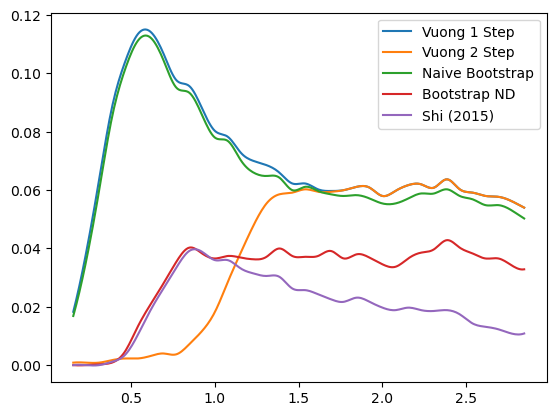

In [7]:
nobs =250
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)

2.2786950120053917 -3.2345062852264332 6.195603707544986
-6.400397121195069 -3.2345062852264332 -2.483488425655475
---
6.89124973317993 -5.806753093987105 10.33121995479122
-10.572557460768456 -5.806753093987105 -7.132587239157169
---
8.971990099061706 -5.45302710603712 12.584690362200337
-12.86499709263158 -5.45302710603712 -9.252296829492948
---
-1.7514902290794523 0.6226507981371563 2.2858387829568887
-2.53875302020638 0.6226507981371563 1.498575991829961
---
-1.615681872581087 0.26574594479304864 2.4017812322471928
-2.552168045951508 0.26574594479304864 1.4652950588767721
---
-1.3504377502839644 0.5136969302261458 2.459363550254491
-2.4284895089698084 0.5136969302261458 1.3813117915686468
---
0.5682353377372412 -1.7304471223732136 4.572525782242446
-4.955472958460183 -1.7304471223732136 -0.951182513954978
---
-1.0002885356107412 -0.41675801844634314 3.062814040779816
-3.2217433494264633 -0.41675801844634314 0.8413592269640933
---
-1.014047656104483 -0.3946595621183047 2.93945396439

1.1918808475929978 -1.9742206673508247 4.8011236988923125
-4.803594299100458 -1.9742206673508247 -1.1943514478011428
---
-1.3969037097905483 0.09639415307684783 2.7127257080478424
-2.9694410407397336 0.09639415307684783 1.1401883770986574
---
2.7363845767397152 -3.13266876024522 6.382884744531211
-6.292564172222062 -3.13266876024522 -2.6460640044305674
---
6.082652546607779 -4.274541515259935 9.751312528790082
-10.123002098883429 -4.274541515259935 -6.454342116701127
---
-0.45045782859550815 -0.805232496146727 3.3938766547911645
-3.3097705730291156 -0.805232496146727 0.5345639103575569
---
5.802084142217411 -3.3581317020971686 9.12092202709466
-9.01019249694383 -3.3581317020971686 -5.691354612066579
---
-1.5203749819818033 0.6066314495193533 2.515840475987602
-2.5715466155915885 0.6066314495193533 1.464668842377817
---
0.009777783452308668 -1.2721054783438308 3.997891655989054
-4.072806962318156 -1.2721054783438308 -0.08469308978141075
---
25.726846636940593 -13.118162880127308 28.4729

-1.0363828013052112 -0.34114377186458533 2.967656169314104
-3.049631634617365 -0.34114377186458533 0.95440733600195
---
2.614744858655845 -4.765135393358543 6.589293922509119
-6.684078342307487 -4.765135393358543 -2.7095292784542124
---
-0.8558405202575613 -0.1530013811532267 2.968685179747525
-2.984561942224903 -0.1530013811532267 0.8399637577801837
---
1.5360510130071439 -2.116803914006614 5.390172178733913
-5.631293805751569 -2.116803914006614 -1.7771726400248
---
-1.3671569717862084 0.31844318137089433 2.353757962745369
-2.4841688258439008 0.31844318137089433 1.2367461086876768
---
-0.43940194475253375 -1.1213415549952046 3.4350426989326013
-3.4901820696987307 -1.1213415549952046 0.3842625739864041
---
-0.7496064854127295 -0.9130306065824585 3.0152777015558505
-2.791506876930413 -0.9130306065824585 0.9733773100381667
---
-1.4650837901589335 0.27505456405105544 2.2676136761562065
-2.3703012551284512 0.27505456405105544 1.3623962111866887
---
-1.5092827338981756 0.43463432042206995 2

-1.280661595067662 0.06058453686797911 2.5027212637963285
-2.3049138724612925 0.06058453686797911 1.4784689864026979
---
-0.517201490798772 -1.5210049166936814 3.5980833615983214
-3.577372598533906 -1.5210049166936814 0.5379122538631875
---
-1.2879972601167766 -0.9361479974084321 2.7584372556220615
-2.74683486551419 -0.9361479974084321 1.2995996502246483
---
-0.6620364521320806 -0.9138400907781782 3.0897991075590148
-3.020688943194614 -0.9138400907781782 0.731146616496481
---
-1.3265009854179648 -0.29281449274653437 2.366832635755721
-2.4768855643813286 -0.29281449274653437 1.2164480567923577
---
-1.6311113688146097 0.8890386319513377 2.4579405639162393
-2.312656043296874 0.8890386319513377 1.7763958894339749
---
-1.5308468975084042 1.089191127001125 2.419402550001348
-2.1734796938372254 1.089191127001125 1.7767697536725267
---
-0.7765518598434492 -1.7472240480517156 3.1959460919832017
-3.4035403849840944 -1.7472240480517156 0.5689575668425564
---
0.16511316661541361 -1.959390522227448

-1.3632117154057075 -0.17314538910288924 2.5983625941759767
-2.549889850693797 -0.17314538910288924 1.4116844588878867
---
-1.301013333182489 -0.7353525715240019 2.734580772160934
-2.902517536089249 -0.7353525715240019 1.1330765692541744
---
-1.0500700366416524 -0.8562872828212051 2.604850741492433
-2.7371370177164462 -0.8562872828212051 0.9177837604176395
---
-1.651089685307413 1.2462213656361643 2.3522509096242876
-2.281688400516137 1.2462213656361643 1.7216521944155634
---
-0.792781040334323 -2.1341415128345096 3.013130599797301
-2.9702378695616636 -2.1341415128345096 0.8356737705699603
---
-1.5969518365852156 0.6286486445421419 2.3622780301374453
-2.261023811362993 0.6286486445421419 1.6982060553596678
---
-1.5773647085922573 -0.14759978518375258 2.5026635780585145
-2.465097973915041 -0.14759978518375258 1.6149303127357306
---
-1.4794680919003123 0.3932180489252746 2.334329535360706
-2.3245999212555404 0.3932180489252746 1.4891977060054777
---
-0.42975973181728605 -1.86889596718508

-1.7072621247837578 1.2208266293304322 2.1424335678021635
-2.2020991312947227 1.2208266293304322 1.6475965612911985
---
-0.7985363332140382 -2.2599476931498774 3.0845112168838806
-3.1439451958653493 -2.2599476931498774 0.7391023542325694
---
-1.6915762175497064 -0.6073434828190342 2.4230582752603937
-2.7032401516084064 -0.6073434828190342 1.4113943412016934
---
-1.739953088236162 -0.35804779274206255 2.501326135652384
-2.697057192800897 -0.35804779274206255 1.544222031087649
---
-1.6193879579127934 0.6928259022764162 2.2358398532194186
-2.17923235889762 0.6928259022764162 1.675995452234592
---
-1.5465880833265904 0.26954737740182105 2.351585463755654
-2.2678171472776603 0.26954737740182105 1.6303563998045842
---
-0.4148635308971151 -5.777108875295963 3.9088575441302393
-4.101002455499554 -5.777108875295963 0.2227186195278007
---
-1.6658839834233174 0.24163236707712024 2.397003138213499
-2.405925167028735 0.24163236707712024 1.6569619546080814
---
-1.5850412753305159 -0.6716411748872101

-1.3134991874247497 -0.15747109516671165 2.3774980491585604
-2.073904504199768 -0.15747109516671165 1.617092732383542
---
-1.373216411144079 -2.284294711702877 2.6771009298386246
-2.8294418810971744 -2.284294711702877 1.220875459885529
---
-1.5834748828970282 -0.19715125913861586 2.393436346782085
-2.380392817732412 -0.19715125913861586 1.5965184119467015
---
-1.6073147791498803 0.293916524478506 2.358025356258021
-2.39677141081071 0.293916524478506 1.568568724597191
---
-1.7387627728728154 0.914163654232621 2.2700522901807925
-2.1347599095444054 0.914163654232621 1.8740551535092023
---
-1.7264643790149576 0.46753995313478725 2.2695901388965334
-2.2729343191246993 0.46753995313478725 1.7231201987867917
---
-1.4754589216903913 -1.7392758704133748 2.5416979034752814
-2.791750780923012 -1.7392758704133748 1.2254060442426609
---
-1.6555005215206944 -0.6430760283693061 2.3842139795881008
-2.455432998310709 -0.6430760283693061 1.584281502798086
---
-1.3137293977298234 -2.9335334969827174 2.7

-1.689169299990395 0.0019193862101746194 2.3131438581469235
-2.2987724679888086 0.0019193862101746194 1.703540690148509
---
-1.8585678540820518 0.010225966349041438 2.303908661730444
-2.5002410345925963 0.010225966349041438 1.6622354812198996
---
-1.792166129165123 -0.23958766875247775 2.3094575287039607
-2.39137408984472 -0.23958766875247775 1.7102495680243637
---
-1.6974266040250572 -1.2889934255990003 2.338592002367633
-2.5415035795167795 -1.2889934255990003 1.4945150268759102
---
-1.612246656495709 -0.9930550288483256 2.396625718237095
-2.41968030907546 -0.9930550288483256 1.5891920656573444
---
-1.670782808039897 -0.090410615669777 2.356044668317291
-2.377895776947941 -0.090410615669777 1.648931699409247
---
-1.7740700612745561 -0.2508832443179589 2.187928305256468
-2.337454992652935 -0.2508832443179589 1.6245433738780892
---
-1.6674026492078555 -0.7307243769320019 2.0601496060854165
-2.320062924819938 -0.7307243769320019 1.4074893304733338
---
-1.7185039690565291 1.39575266796775

-1.9220660987670184 1.5425469648324546 2.0478193097390682
-2.298164657572202 1.5425469648324546 1.6717207509338845
---
-1.3204416938176142 -3.408718420649343 2.6186855911104416
-2.7833596036241044 -3.408718420649343 1.1557676813039512
---
-1.7367494040465263 -0.4418785657405316 2.0845537924930775
-2.2927475434675473 -0.4418785657405316 1.5285556530720565
---
-1.7802486571976728 -1.3673157435281877 2.4010307220464018
-2.6887346180139367 -1.3673157435281877 1.4925447612301377
---
-1.5969984781586677 -0.1164314392246578 2.226058548780647
-2.1399690519823578 -0.1164314392246578 1.6830879749569565
---
-1.7328617718737074 -0.894831872373113 2.3811431734834847
-2.4407653510383867 -0.894831872373113 1.6732395943188052
---
-1.6592389514989219 -0.05515441339490702 2.2609528883702708
-2.1231683590339587 -0.05515441339490702 1.7970234808352337
---
-1.2991514307916998 -2.295911945936696 2.501361533481303
-2.4240744379992685 -2.295911945936696 1.376438526273734
---
-1.8349933639304856 1.381119960780

-1.841040824008715 -1.3299478498731878 2.268864145664891
-2.4832122228820293 -1.3299478498731878 1.6266927467915768
---
-1.5899084209138141 -0.7183057889020932 2.2301750627601504
-2.1242417148395702 -0.7183057889020932 1.6958417688343945
---
-1.7904359130256273 0.3218224555774602 2.1503574355287354
-2.1978921418347745 0.3218224555774602 1.742901206719588
---
-1.5766808726304966 -1.1796820892073943 2.2771345830336394
-2.1976073630973527 -1.1796820892073943 1.6562080925667835
---
-1.62882667458688 -3.277533622427876 2.4594204048480073
-2.555408038127077 -3.277533622427876 1.532839041307811
---
-1.767940351428735 0.38060265938315213 2.3942465183030266
-2.2023250174203635 0.38060265938315213 1.9598618523113984
---
-1.8239818072384035 1.1836123372356648 2.313324839353873
-2.202681944195621 1.1836123372356648 1.9346247023966556
---
-1.6532267776416454 -0.9599311957377066 2.293624899196465
-2.2584270842579164 -0.9599311957377066 1.6884245925801937
---
-1.5731702622606265 -0.001798448751838768

-1.83410909790024 0.4573752551628653 2.1058311813771424
-2.27699443940228 0.4573752551628653 1.662945839875102
---
-1.7777579917535122 1.0860285699938623 2.2700321608846856
-2.1100309319094914 1.0860285699938623 1.9377592207287069
---
-1.700221188185737 0.750578387169126 2.5094586318786574
-2.0055164574994313 0.750578387169126 2.2041633625649633
---
-1.6044227265055888 -1.0786317484367747 2.1811623635032222
-2.162432857413404 -1.0786317484367747 1.6231522325954064
---
-1.691223889507033 0.46137498245657355 2.1490012299613217
-2.0503537575157087 0.46137498245657355 1.7898713619526456
---
-1.8023897484080296 -0.8142021608172235 2.1123207331756726
-2.3246831659980423 -0.8142021608172235 1.5900273155856601
---
-1.7885310794426645 -0.794109441513379 2.222553946851068
-2.31407952370475 -0.794109441513379 1.6970055025889825
---
-1.7288749554988294 0.6962726494941386 2.0485647227314656
-2.081673726259318 0.6962726494941386 1.6957659519709773
---
-1.8595571239554525 0.5180506563165922 2.1509946

-1.796359253326493 -0.7485474141193836 2.267118777448029
-2.2430245414254886 -0.7485474141193836 1.8204534893490334
---
-1.8518838575379701 0.8668315555860004 2.186694156316979
-2.175926636893505 0.8668315555860004 1.862651376961444
---
-1.8594395994650237 0.3741861886891173 2.175116556822214
-2.2206546297896472 0.3741861886891173 1.8139015264975906
---
-1.788186591049745 -0.6365715631446709 2.2116906894742314
-2.2542943764850363 -0.6365715631446709 1.7455829040389406
---
-1.9473010694778523 -1.2326742331705303 2.2100682288048588
-2.4422460103726173 -1.2326742331705303 1.7151232879100935
---
-2.002207843630762 -2.1978672850823955 2.2112041319466993
-2.6444932367667704 -2.1978672850823955 1.568918738810691
---
-1.7232603847602759 0.34281400155771763 2.2153509272795184
-2.0335774651518297 0.34281400155771763 1.9050338468879642
---
-1.796108937912732 0.6295502275622838 2.3236026694703336
-2.116606358906799 0.6295502275622838 2.003105248476267
---
-1.6774877375521953 0.08443404729058879 2.

-1.8287936186473281 -0.15000651186624275 2.1619894446897563
-2.172655745530433 -0.15000651186624275 1.818127317806651
---
-1.8199946830866311 -0.7102145509299405 2.188055237956299
-2.226015935199133 -0.7102145509299405 1.7820339858437972
---
-1.7747043640948643 -1.9742782106201702 2.132315010154303
-2.274078996432527 -1.9742782106201702 1.6329403778166405
---
-1.7107623288080502 -1.0963699701666054 2.378632965090564
-2.135341703105606 -1.0963699701666054 1.9540535907930079
---
-1.7869870055533068 0.5729948003307626 2.261994902345336
-2.1475554293533468 0.5729948003307626 1.9014264785452963
---
-1.8064916503412476 -1.0089911632523205 2.1905438479792196
-2.2291823195046185 -1.0089911632523205 1.7678531788158485
---
-1.8848321615299202 0.9052874810316407 2.2094923385026326
-2.1799915179397558 0.9052874810316407 1.9143329820927968
---
-1.9006764545596853 0.8011085906468656 2.0840108638516215
-2.1967711729391173 0.8011085906468656 1.7879161454721895
---
-1.7821378904605114 -0.65588975006228

-1.706634196024931 -1.5806402328835505 2.233795050790611
-2.13876925445271 -1.5806402328835505 1.801659992362832
---
-1.6717958613192772 -1.3003408912167742 2.1056130623557423
-2.1347541437029043 -1.3003408912167742 1.6426547799721152
---
-1.806478641019567 -1.2791948471156855 2.181875222009348
-2.247372323167579 -1.2791948471156855 1.7409815398613357
---
-1.7746880753444625 1.1189775854750459 2.1652584254527714
-2.0653788318060906 1.1189775854750459 1.874567668991143
---
-1.8991340512519492 1.7094742851942533 2.1843314149054516
-2.0932808303207113 1.7094742851942533 1.9901846358366893
---
-1.9487131872879049 -1.4705157820920536 2.381955606458232
-2.3343953545006704 -1.4705157820920536 1.9962734392454669
---
-1.6522022572405453 2.938147549836835 2.3786932446404068
-1.8802304551906497 2.938147549836835 2.1506650466903023
---
-1.8095685566288158 -0.11018359515253337 2.192141679698979
-2.1052046704605263 -0.11018359515253337 1.8965055658672685
---
-2.0166807452720303 0.9324128722726547 2.

-2.0625362449363025 -0.9338167771495335 2.0476723225082227
-2.4115317142383517 -0.9338167771495335 1.6986768532061738
---
-1.8047910069520896 -0.1469130427007063 1.9771113723632883
-2.1273053158941524 -0.1469130427007063 1.6545970634212257
---
-1.9596884921699975 0.7698204677635575 1.9820127610640026
-2.2230911005830243 0.7698204677635575 1.7186101526509758
---
-1.781593117858535 0.5003007025067837 2.1140948210197985
-2.080017202350924 0.5003007025067837 1.8156707365274092
---
-1.986554320391021 1.4343575324727709 2.024450801684558
-2.201317454798043 1.4343575324727709 1.8096876672775355
---
-1.9197767897573201 1.598441539830607 2.2618974110103305
-2.1486332477864534 1.598441539830607 2.0330409529811972
---
-1.9264424491474625 0.8887061545559973 2.123012271628766
-2.1534030343445805 0.8887061545559973 1.896051686431648
---
-1.707132456163033 -0.23611500198930327 2.278679318381459
-2.086427190341703 -0.23611500198930327 1.8993845842027894
---
-1.9631197995917702 0.4585525710862677 2.014

-1.7224271173680554 -1.4806288634315277 2.1894943427989566
-2.09436894360686 -1.4806288634315277 1.8175525165601514
---
-1.8228931734118274 0.683101400020333 2.0753856111473254
-2.04320616895322 0.683101400020333 1.855072615605933
---
-1.8411895148310804 0.5940902906888622 2.2021366497538075
-2.1136609835179114 0.5940902906888622 1.9296651810669763
---
-1.6086882490047953 -0.042392439442466595 2.055725045245422
-1.8842177109896987 -0.042392439442466595 1.7801955832605185
---
-1.9238588572014228 0.40213357038238234 2.2204416674118796
-2.1608257487004394 0.40213357038238234 1.9834747759128626
---
-1.8874616273003912 -1.8164568173470474 2.233897020697861
-2.3029627807208097 -1.8164568173470474 1.8183958672774427
---
-1.836991716484975 -0.4344509356413821 2.1355254234746117
-2.1425100068016936 -0.4344509356413821 1.8300071331578929
---
-1.7977972052998463 1.1957949008349458 2.0711413169632125
-2.03976317322032 1.1957949008349458 1.8291753490427385
---
-1.854140509774662 0.7323130777549354 

-1.8548278931948687 0.8905244637210252 2.0462676824988355
-2.0976808834676737 0.8905244637210252 1.8034146922260301
---
-1.8989887995129124 -0.8645087797127279 2.075437059378379
-2.230042058430647 -0.8645087797127279 1.7443838004606442
---
-1.8959643980305405 -1.2943612634270756 2.077212638447015
-2.221004783289648 -1.2943612634270756 1.7521722531879076
---
-1.9484463610176481 1.7778736152147607 2.303140304062173
-2.1673703020909056 1.7778736152147607 2.0842163629889154
---
-1.9195728520218174 0.10383469008972959 2.088667522252025
-2.2216117805588214 0.10383469008972959 1.7866285937150213
---
-1.6875487904844468 -0.8680604544356151 2.216484709042523
-2.02485757865488 -0.8680604544356151 1.879175920872089
---
-1.8850762081518269 0.6818701970062373 2.089868413260194
-2.141445914049044 0.6818701970062373 1.8334987073629767
---
-1.8115368590754481 -1.443817451493269 2.038334228549341
-2.195288615946201 -1.443817451493269 1.6545824716785886
---
-1.9261137317404757 0.9185710342611068 2.17732

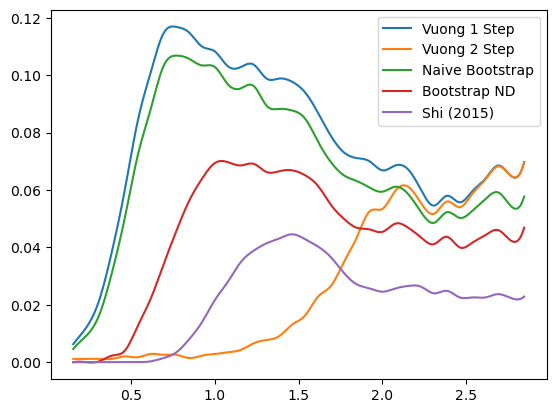

In [8]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)

# Extra Power Sims

-1.0154677095016034 0.5542134585259789 3.078515163627869
-3.2926895586747964 0.5542134585259789 0.8012933144546753
---
8.11903717418982 -2.9402155571264363 11.794744925227828
-11.608259625036844 -2.9402155571264363 -7.932551873998835
---
-0.3667478014792434 0.02567993378034154 3.2824061608639394
-3.4051259806115066 0.02567993378034154 0.24402798173167575
---
16.480315752871494 -5.312941593957492 20.210637207487984
-20.48217082265892 -5.312941593957492 -16.75184936804243
---
-1.0255273009438914 0.5373827829357849 2.943589777529857
-2.9489324731850908 0.5373827829357849 1.0201846052886578
---
0.31830762395532397 -0.22640657637902534 4.162928840223515
-4.250578559951304 -0.22640657637902534 -0.4059573436831138
---
0.845251075543495 -0.6359976251759232 4.60015004025081
-4.455009145577984 -0.6359976251759232 -0.7001101808706689
---
1.9524040129763174 -1.0921158627844636 5.8231699214217825
-5.797947403157633 -1.0921158627844636 -1.9271814947121682
---
1.2117113824076309 -0.8296809282539709 5

1.330663090830273 -1.447537834393965 5.030425653161022
-5.227056724820092 -1.447537834393965 -1.527294162489342
---
3.98119277636117 -2.1754417353115714 7.957780095262116
-7.8778865350922835 -2.1754417353115714 -3.901299216191339
---
2.0401722239254547 -1.2292158429932447 5.97095499871982
-6.016232300805431 -1.2292158429932447 -2.085449526011066
---
-1.2153819258305363 0.940539753882871 2.7339772547705836
-2.750788500119463 0.940539753882871 1.1985706804816563
---
-1.0824055971433446 0.5020199574638787 2.8605840473875186
-2.7799514919800195 0.5020199574638787 1.1630381525508438
---
3.048013916625506 -2.24098548473757 7.092110606141618
-7.344922686660763 -2.24098548473757 -3.3008259971446523
---
-0.7005040085250523 0.16665129382512484 3.210170629988554
-3.209932021715608 0.16665129382512484 0.7007426167979977
---
-0.1741655190498054 -0.6552177420547174 3.7969177680064927
-3.756778354476351 -0.6552177420547174 0.21430493257994693
---
-1.1926443698085694 0.6834677159769347 2.8428880540418

5.764963967123319 -4.395166047695854 9.602285196649488
-9.6373212214039 -4.395166047695854 -5.799999991877731
---
3.1732126739975035 -4.206338403741598 6.813848276973201
-6.813928624845823 -4.206338403741598 -3.173293021870125
---
-1.126571782620589 0.15618016670094131 2.6818492534877025
-2.582574253426443 0.15618016670094131 1.2258467826818482
---
2.451249354944721 -3.5943913997206716 6.330198142293086
-6.468380239607512 -3.5943913997206716 -2.5894314522591473
---
0.09697562691779915 -1.1137253255090478 3.8000414714008786
-3.8774053754225655 -1.1137253255090478 -0.17433953093948576
---
0.8510263171408728 -2.0332335865810895 4.857592691332672
-4.787053130148646 -2.0332335865810895 -0.7804867559568459
---
1.1387012659507318 -1.8085824766818184 4.963795253579028
-5.103369218775251 -1.8085824766818184 -1.278275231146954
---
3.4519142447849784 -3.3530496145877366 7.2177603887444235
-7.2130768904097415 -3.3530496145877366 -3.447230746450296
---
-0.08052532659181671 -0.42602540704682385 3.89

-1.2815021720881417 0.6292908891557333 2.518942832115371
-2.3943542751025495 0.6292908891557333 1.406090729100963
---
1.752983341432342 -4.326511430741639 5.6300515239893745
-5.7052287561752575 -4.326511430741639 -1.8281605736182258
---
1.5073827650676366 -3.1057326942735624 5.486613055437518
-5.7116927844077345 -3.1057326942735624 -1.7324624940378541
---
-0.9442365552529038 -0.735481213842317 3.160345457990995
-3.1703823976716 -0.735481213842317 0.9341996155722985
---
2.5960184525472556 -5.62354192238822 6.341655026946293
-6.543378681420336 -5.62354192238822 -2.797742107021299
---
2.4956994584590717 -5.592346067522745 6.508393372157413
-6.308702717721273 -5.592346067522745 -2.2960088040229314
---
1.7642509230126142 -5.218634490914283 5.7988899038345725
-5.851109078218117 -5.218634490914283 -1.816470097396158
---
2.6083363530062855 -3.8321450586392523 6.484588971523724
-6.83189965254674 -3.8321450586392523 -2.955647034029301
---
1.2294496505791588 -4.545718694924268 5.095322283972537
-

-1.1333997751872462 -1.595567893198473 3.1201958378574326
-3.434686602768712 -1.595567893198473 0.8189090102759669
---
-1.2394652239842328 -0.9149230463088096 2.665196651847645
-2.8585180589786585 -0.9149230463088096 1.0461438168532196
---
-0.947417840789052 -1.7697255022031313 2.95160421400476
-2.998994166648779 -1.7697255022031313 0.9000278881450328
---
-1.366771249334779 0.5836371491393733 2.5708525074167294
-2.526546738101345 0.5836371491393733 1.4110770186501636
---
-1.3383743870447076 -0.19139854411567614 2.720976947553719
-2.65154551941792 -0.19139854411567614 1.4078058151805064
---
-0.8339619987306449 -1.7200314690975391 3.00609106459803
-2.933519440923167 -1.7200314690975391 0.9065336224055082
---
0.5039845274939089 -7.066063638813199 4.769064329099746
-5.161131597225445 -7.066063638813199 -0.8960517956196082
---
0.7925402638638755 -6.780734334251892 5.154228755137635
-5.28415715471469 -6.780734334251892 -0.9224686634409301
---
1.0547441691841426 -6.252931860064531 5.187135000

-0.5043886346006708 -5.376998019234673 3.950074123399913
-4.235799827182254 -5.376998019234673 0.21866293081832913
---
-0.8839136564448157 -2.9989564976995715 3.2048266895784785
-3.253627974690478 -2.9989564976995715 0.835112371332816
---
0.9608449284402558 -7.3795028685132795 4.983222744158742
-4.839309139821418 -7.3795028685132795 -0.8169313241029322
---
-0.5773554710564075 -3.0225703498902785 3.1935600208619395
-3.014761253260264 -3.0225703498902785 0.7561542386580831
---
-0.03868757049805128 -6.102373974868373 3.841528670513619
-4.0639033050931515 -6.102373974868373 -0.18368706408148133
---
0.39762589395282594 -7.430139712891311 4.424307042981202
-4.726158658333143 -7.430139712891311 -0.6994775093047674
---
-0.646749501509922 -4.993567793775807 3.56681506191887
-3.773018512316255 -4.993567793775807 0.44054605111253675
---
0.3159288844639566 -5.529443951230291 4.29707515136687
-4.763722731731577 -5.529443951230291 -0.782576464828664
---
-0.6518866646723098 -3.2964214488101655 3.1430

-0.46074160364819217 -6.941011480354714 3.4583291296573737
-3.5055897162968637 -6.941011480354714 0.4134810170087021
---
-0.7794623311157365 -4.368429156224336 3.187203826677898
-3.4325759275114325 -4.368429156224336 0.5340902302822023
---
0.14025332705218924 -8.501749371239159 3.9932582119545263
-4.041066687795393 -8.501749371239159 -0.18806180289305582
---
-0.29555776211742096 -6.67961904698961 3.6094636608459565
-3.5279850407720224 -6.67961904698961 0.3770363821913551
---
-0.6053560929253702 -5.5943287140715805 3.480424297081682
-3.511055040458908 -5.5943287140715805 0.5747253495481439
---
-1.0887168078128466 -3.033012344984361 2.8008395149592102
-2.8474293464046596 -3.033012344984361 1.0421269763673973
---
-1.0006009921620005 -3.8185225636392333 2.92253827094883
-2.9221689394705224 -3.8185225636392333 1.0009703236403078
---
-0.40099794649409265 -7.009534504393182 3.608830747392635
-3.7201161252002177 -7.009534504393182 0.28971256868651013
---
-0.26322452335459406 -8.896172625514208

-0.7234140195046894 -6.893638104845433 3.377842938625661
-3.2027062226551246 -6.893638104845433 0.8985507354752258
---
-0.9915773127160573 -8.287150455085904 3.5176723924335382
-3.683405076921012 -8.287150455085904 0.8258446282285841
---
-1.0116580784185951 -6.679986926709004 3.165886025007547
-3.5033534892686315 -6.679986926709004 0.6741906141575106
---
-1.3346031747473013 -3.5674932013721232 2.6765595899906827
-2.744659860798872 -3.5674932013721232 1.2665029039391116
---
-0.5498685655625342 -11.336734410002132 3.858201531347231
-4.10951315680374 -11.336734410002132 0.2985569401060241
---
-1.3983496381067704 -3.1616066339293245 2.682490356149032
-2.7792470815535006 -3.1616066339293245 1.3015929127023025
---
-0.17788627679020722 -9.308494550213284 3.7994838801572297
-4.073128103312299 -9.308494550213284 -0.0957579463648619
---
-0.6913226069497704 -8.293700030102364 3.4972649529651307
-3.8043092240490473 -8.293700030102364 0.384278335865854
---
-0.5352247482813204 -10.081514961312525 3.

-1.3531740636930965 -4.105669195107529 2.691915404394852
-2.8326794716839316 -4.105669195107529 1.212409996404017
---
-1.295313485803105 -4.21896418612347 2.6723657052805083
-2.7338181906519696 -4.21896418612347 1.233861000431644
---
-0.6234021578655948 -11.553601655137033 3.4899159559595647
-3.8035870415622135 -11.553601655137033 0.30973107226294594
---
-0.9936672176992553 -7.767121617535563 2.912499411198449
-3.2110399875917146 -7.767121617535563 0.6951266413059899
---
-0.5497122116115067 -11.013793388304826 3.6759230225915793
-3.8875310912282512 -11.013793388304826 0.33810414297483504
---
-1.410026447607248 -5.007850465971193 2.710138778455496
-2.892025686266208 -5.007850465971193 1.2281395397965356
---
-1.292175853210768 -4.4897678134333505 2.6101127188704454
-2.627531471703449 -4.4897678134333505 1.2747571003777638
---
-1.1308686800590089 -7.523015290033528 2.8581268781380222
-3.228717226689473 -7.523015290033528 0.7602783315075582
---
-1.0531983624415313 -12.430485015528388 3.627

-1.386692473955058 -8.517781370057987 3.1640096345526567
-3.4424018349584538 -8.517781370057987 1.1083002735492606
---
-1.1417966906976076 -9.556274815473289 2.9185378847866374
-3.2247567321276898 -9.556274815473289 0.8355778433565552
---
-0.708610611212696 -13.054135590854738 3.5593314113734382
-3.476479251813223 -13.054135590854738 0.7914627707729112
---
-1.4387475682933581 -7.661203055671822 2.860763608784929
-3.197925241134881 -7.661203055671822 1.1015859359434057
---
-1.3329807873594979 -5.1785188980007275 2.5833444979801654
-2.5604064319733153 -5.1785188980007275 1.355918853366348
---
-0.7561610477419768 -14.410225134555557 3.4537167011177967
-3.562639267194647 -14.410225134555557 0.6472384816651262
---
-0.7360339784511121 -12.552943561749556 3.5225050028825713
-3.583650808998715 -12.552943561749556 0.6748881723349687
---
-1.1937513935595856 -11.742555409243064 3.57836031246174
-3.7319179400742133 -11.742555409243064 1.040193765947112
---
-1.2132006229603711 -6.841109618846411 2.

-1.2361619711281842 -7.163297208803659 2.6673714203419165
-2.720905831828051 -7.163297208803659 1.18262755964205
---
-1.3787342281117836 -7.991902089564169 2.732836671001388
-3.0153801507901563 -7.991902089564169 1.0961907483230156
---
-1.6476886582355128 -14.573089482983816 3.6104298937038433
-4.19011060197214 -14.573089482983816 1.0680079499672146
---
-1.3105638910460806 -15.001731598650007 3.526298015381083
-3.8520734409145683 -15.001731598650007 0.9847884655125947
---
-1.322756669020297 -10.984630747370906 3.115332156217342
-3.4276844925032925 -10.984630747370906 1.0104043327343466
---
-1.329260294147473 -9.664082835203871 3.023139214189297
-3.283940089748659 -9.664082835203871 1.0684594185881107
---
-1.0478702307700563 -14.221329510063264 3.3297719635872856
-3.660448352781555 -14.221329510063264 0.7171938415757868
---
-1.295619939429394 -12.77830481346247 3.430147053682935
-3.6687268440429497 -12.77830481346247 1.0570401490693793
---
-1.1971625235280787 -8.763478169054622 2.837956

-1.3865704351431987 -15.786587501258671 3.2489045639938947
-3.6512721089063653 -15.786587501258671 0.9842028902307278
---
-1.4966633992170322 -13.509943521573323 3.1078101961694267
-3.577592744028306 -13.509943521573323 1.0268808513581524
---
-1.6457941951013912 -14.214892948404774 3.1748531705841776
-3.6174764574259317 -14.214892948404774 1.203170908259637
---
-1.5903345944502245 -7.009144511436855 2.556482854982246
-2.7043814397527424 -7.009144511436855 1.442436009679728
---
-1.3354182050924996 -14.252256772799436 3.3144464338460575
-3.354787295564619 -14.252256772799436 1.295077343373938
---
-1.5170786109514591 -11.857834774891398 2.9899470057401856
-3.4334033681643383 -11.857834774891398 1.0736222485273064
---
-1.4134061005775347 -16.592015084274337 3.3409440519733833
-3.8254079502104035 -16.592015084274337 0.9289422023405145
---
-1.5502348612273238 -16.468733195035608 3.393229853984787
-3.8582468767464912 -16.468733195035608 1.0852178384656193
---
-1.4714244958995986 -12.896519213

-1.3612495395354616 -16.56645771405105 3.1104418433030765
-3.5060287485930166 -16.56645771405105 0.9656626342455215
---
-1.4340320370069914 -16.193936114484234 3.1125828897392434
-3.4250366245147084 -16.193936114484234 1.1215783022315262
---
-1.4501996743333405 -12.86200499703787 2.8098479578475395
-3.1321105866449765 -12.86200499703787 1.1279370455359035
---
-1.4123296113007986 -14.38537424836759 3.0349602307810453
-3.2195285323951226 -14.38537424836759 1.2277613096867215
---
-2.0477435790385647 -14.293380056991902 3.3616898556734887
-3.7627155473021783 -14.293380056991902 1.646717887409875
---
-1.5531863435051565 -17.484679427468656 3.309625973030451
-3.688481326629354 -17.484679427468656 1.1743309899062535
---
-1.3524570253650818 -13.54122532594397 2.802239663700725
-3.014296660800953 -13.54122532594397 1.1404000282648539
---
-1.1763112013911448 -17.736124664413435 3.205541826877739
-3.44090850264863 -17.736124664413435 0.9409445256202537
---
-1.4481096840103 -16.917806509980196 3.1

-2.0535039155639607 -19.222941391244156 3.422440842813835
-3.937944631916829 -19.222941391244156 1.5380001264609666
---
-1.4088960033371782 -16.835775263769033 2.8049146297744056
-3.1107813439562424 -16.835775263769033 1.1030292891553415
---
-1.6066240674995087 -17.50932387054384 3.035466206174612
-3.526785578859132 -17.50932387054384 1.1153046948149887
---
-2.0722476498418145 -16.720628371461704 3.162697624690594
-3.6914836822532817 -16.720628371461704 1.5434615922791268
---
-1.6037164399355393 -9.321340514604184 2.6259632957047545
-2.7287490361747273 -9.321340514604184 1.500930699465567
---
-2.0705653174360856 -19.933353579783116 3.4023079406884005
-3.969432738996858 -19.933353579783116 1.5034405191276285
---
-1.7457133159666063 -15.38433237520254 2.9647440978464545
-3.356487682337105 -15.38433237520254 1.353969731475956
---
-1.4440037627832036 -14.051640149941191 2.807503818523882
-3.000450316289894 -14.051640149941191 1.2510572650171914
---
-1.5979002846545012 -16.103191397017312 3

-2.2740553170172895 -20.043226214005355 3.442202071086478
-4.096647786987068 -20.043226214005355 1.619609601116699
---
-1.8419200472601225 -20.261713781649178 3.134922099535998
-3.7591596354456054 -20.261713781649178 1.2176825113505154
---
-1.9228749086845462 -18.030409879561667 3.1395254742768754
-3.5794560393983836 -18.030409879561667 1.482944343563038
---
-1.7442983905414258 -20.15085216435133 3.3936335304758907
-3.6260408890305915 -20.15085216435133 1.5118910319867254
---
-1.9377859500017334 -15.242873219403567 2.8572337865706
-3.221735631206864 -15.242873219403567 1.5732841053654696
---
-1.7240581799696348 -20.527597437378084 3.316449330157966
-3.6965963449377113 -20.527597437378084 1.3439111651898894
---
-2.051103832023749 -20.31818299273715 3.273217499997027
-3.905301569641704 -20.31818299273715 1.4190197623790717
---
-2.007668414675888 -19.86740226047113 3.473402714764035
-3.7113561702544127 -19.86740226047113 1.7697149591855106
---
-1.6409745100220667 -21.634342985248733 3.244

-1.8373820069446827 -18.222094050636958 3.0658346277714856
-3.3581305107025328 -18.222094050636958 1.545086124013636
---
-1.9166282781704587 -17.353493565765984 2.778509843891667
-3.228009738194193 -17.353493565765984 1.467128383867932
---
-2.3648799160494463 -18.571992844991893 3.4066313318730974
-3.684381639240753 -18.571992844991893 2.0871296086817908
---
-2.0912790494658555 -18.937837270367513 3.047101250540502
-3.6090705919339374 -18.937837270367513 1.5293097080724203
---
-2.3334854066540087 -20.183968610028924 3.2905965868218665
-3.9380474372763254 -20.183968610028924 1.6860345561995498
---
-1.8568365938257967 -18.65186608242733 2.9280381473811943
-3.389357317798237 -18.65186608242733 1.395517423408754
---
-2.285948947601878 -21.773821654018032 3.3424922619949142
-3.8750821830170414 -21.773821654018032 1.753359026579751
---
-2.046974601111756 -21.81280418457215 3.3830352775173003
-3.7416604686480475 -21.81280418457215 1.688349409981009
---
-1.6322289581947986 -17.072357233703535 

-2.6399712594071074 -23.745635394267627 3.5705036623273565
-4.285568746621751 -23.745635394267627 1.924906175112713
---
-2.159790377916983 -19.617467250835396 3.4602100091989505
-3.5961372797505593 -19.617467250835396 2.0238631073653743
---
-2.16637068936844 -22.939748848071236 3.113254924778674
-3.7797485624576246 -22.939748848071236 1.499877051689489
---
-2.288428844618897 -14.600811164877614 2.811061216080317
-3.3482100894922944 -14.600811164877614 1.7512799712069194
---
-2.3330370984430706 -21.01810855935963 3.0978488130032535
-3.747207787678872 -21.01810855935963 1.6836781237674527
---
-2.0535208403498495 -19.71618011826761 2.862743816983827
-3.4130871488773784 -19.71618011826761 1.5031775084562982
---
-2.544296616764448 -19.529534819579567 3.1356815257386024
-3.9344062920723535 -19.529534819579567 1.745571850430697
---
-2.3935470396087752 -22.449576277785393 3.480585001046807
-3.817957531497717 -22.449576277785393 2.056174509157865
---
-2.5677475047709852 -23.230806400480514 3.51

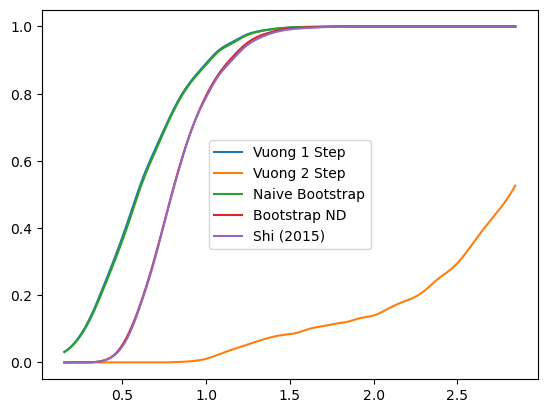

In [9]:
nobs = 250
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2)

In [ ]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2)

6.802989019554898 -1.7103955864403153 10.710628936656173
-10.619358129387994 -1.7103955864403153 -6.7117182122867165
---
-0.2911698629924382 0.4628798117134699 3.5385475609187833
-3.5467734763020564 0.4628798117134699 0.28294394760916547
---
0.20087818205084357 0.18980097602529444 4.168914599803983
-3.8998138158817723 0.18980097602529444 0.06822260187136785
---
7.271829532516627 -1.7966248138012395 10.992471127563947
-10.908831389534392 -1.7966248138012395 -7.188189794487072
---
1.6461951994670967 -0.4630264079962893 5.626034838413155
-5.741652778763747 -0.4630264079962893 -1.7618131398176897
---
1.2172695834742384 -0.2311692570141761 4.995329970204803
-5.134873763772139 -0.2311692570141761 -1.3568133770415745
---
3.207203812058219 -0.8696447065714036 6.922541558184894
-6.960384865353891 -0.8696447065714036 -3.2450471192272166
---
31.468446050720942 -7.73718988137812 35.198498383576236
-35.18684674214272 -7.73718988137812 -31.456794409287426
---
17.46192650746033 -4.091170887721529 21.

-0.30045031046836784 0.19893624826762718 3.5075354489931336
-3.496007862549157 0.19893624826762718 0.3119778969123442
---
0.26302693162529034 -0.15200239792132286 4.2431148303465385
-4.143865613629687 -0.15200239792132286 -0.1637777149084397
---
-0.13515193901891198 0.12564492789766124 3.819330079080576
-3.8731494372965356 0.12564492789766124 0.08133258080295251
---
0.8951866895992522 -0.44935723003989736 4.572747229724019
-4.669630864638589 -0.44935723003989736 -0.9920703245138212
---
9.75220260808494 -2.2311072477308853 13.560925518795772
-13.630025266308337 -2.2311072477308853 -9.821302355597505
---
4.027232300038862 -1.192860059672423 7.942583539667379
-8.051456841755561 -1.192860059672423 -4.136105602127045
---
-0.6857089011233326 0.6329433584138616 3.188077461208349
-3.2775541980500473 0.6329433584138616 0.5962321642816343
---
-0.7773108095533923 0.8196333389832123 3.23881558361108
-3.159922513761301 0.8196333389832123 0.8562038794031712
---
0.5768153948870895 -0.0557953310554031

6.185564632332766 -3.8940671968412106 9.95902453895988
-10.116468073255904 -3.8940671968412106 -6.343008166628788
---
0.9556144746152442 -0.7712614782629612 4.880292608041133
-5.094762907182755 -0.7712614782629612 -1.170084773756867
---
4.886377384516866 -5.407598566101131 8.757906625571426
-8.890201323672246 -5.407598566101131 -5.0186720826176865
---
-0.6017862560566907 -0.2343733705970363 3.2668755035716077
-3.260866668890437 -0.2343733705970363 0.6077950907378612
---
3.5207861255854382 -5.795765489595714 7.149618650140767
-7.310971270025096 -5.795765489595714 -3.6821387454697665
---
-0.47846840540936525 -0.14452543199497953 3.424454945120193
-3.194246712995502 -0.14452543199497953 0.7086766375340564
---
-0.7461420707783214 0.06886200651836061 3.0019645615021835
-3.0442298696375323 0.06886200651836061 0.7038767626429723
---
-0.606575701388284 0.032243060492918384 3.264922021225034
-3.144433088205996 0.032243060492918384 0.7270646344073223
---
1.118166564594462 -1.34048477452153 4.917

-0.42745981217461526 -1.6232798546196567 3.6438611640153913
-3.7450541498162506 -1.6232798546196567 0.3262668263737561
---
-0.4286280762980053 -0.9924516787807711 3.3786195306122524
-3.25272675968689 -0.9924516787807711 0.554520847223368
---
-0.3755301470492706 -1.5994099725179916 3.484394787072444
-3.5937981294844823 -1.5994099725179916 0.26612680463723226
---
-0.39989995432724046 -1.6414227676604831 3.5309652603354658
-3.3830274065835595 -1.6414227676604831 0.5478378080791467
---
1.4395511968268677 -4.2467688540519 5.122320919789317
-4.914229098072829 -4.2467688540519 -1.2314593751103793
---
-0.004392084595038764 -2.44668466541501 3.9563015234881367
-4.143951971706945 -2.44668466541501 -0.18325836362376924
---
0.1907614971932246 -2.466244151776376 4.194980280428783
-4.264120112730509 -2.466244151776376 -0.25990132949495093
---
0.41039603228145555 -2.8055184287566637 4.575043045478777
-4.589872127048743 -2.8055184287566637 -0.4252251138514206
---
-0.20660584327292975 -1.40016284943694

-0.2453136392740744 -3.130187303908695 3.5679293626421043
-3.615593947279025 -3.130187303908695 0.19764905463715365
---
0.4664310710578861 -5.249174754018923 4.661403015737597
-4.818789308954813 -5.249174754018923 -0.6238173642751014
---
1.6438550980096507 -7.968571919474185 5.624521213881457
-5.801245702298805 -7.968571919474185 -1.8205795864269976
---
-0.5442752062935285 -2.6883556525577395 3.629557709429584
-3.6492654648127023 -2.6883556525577395 0.5245674509104106
---
1.2240137412908796 -9.239720242530135 5.0033852682429085
-4.951010776479795 -9.239720242530135 -1.171639249527766
---
1.1308838797122753 -9.013151424852596 5.0806392746192195
-5.2760886092965515 -9.013151424852596 -1.3263332143896078
---
-0.05909762469558358 -3.7154732117610068 3.7882729764558998
-3.6453406788252334 -3.7154732117610068 0.2020299223262501
---
0.385445003079789 -6.04548347583462 4.325344582795579
-4.380186826638746 -6.04548347583462 -0.4402872469229552
---
0.5447903977822459 -5.812911526801423 4.4134399

-0.7414637516596658 -3.675455737594817 3.051379121051492
-3.0896087386599893 -3.675455737594817 0.7032341340511682
---
-0.298014686299846 -4.995408243421284 3.5412997632446834
-3.3773127731094497 -4.995408243421284 0.4620016764350797
---
0.24370192417175954 -6.956368490775018 3.98607705363619
-4.051676650170846 -6.956368490775018 -0.30930152070641515
---
-0.13097871015973467 -7.133367396879185 3.6830534020865193
-3.8102339743497873 -7.133367396879185 0.003798137896466559
---
-0.1758890669314026 -6.421967657428559 3.820262162100668
-3.729494417739359 -6.421967657428559 0.26665681129271185
---
-0.22676084354583917 -5.863010966761343 3.7549880336711654
-3.6595936300723375 -5.863010966761343 0.3221552471446671
---
-0.3163414393170552 -6.517529541249741 3.545662399657703
-3.741891274341265 -6.517529541249741 0.12011256463349322
---
1.0549096894070809 -10.553331568720376 4.865981548954409
-4.930566004726758 -10.553331568720376 -1.11949414517943
---
0.7013815190321643 -9.257991827101014 4.449

-0.77728710296466 -4.768983415068259 3.070759872717074
-3.153386306251687 -4.768983415068259 0.6946606694300469
---
-0.11692848115165563 -8.290450080186963 3.8287632548026878
-3.8528492021942857 -8.290450080186963 0.0928425337600576
---
-0.31006880397379455 -9.414038169493423 3.951945322052116
-4.086622351711128 -9.414038169493423 0.1753917743147825
---
0.7144475315891206 -12.293374925206761 4.494549029914854
-4.583167379400101 -12.293374925206761 -0.8030658810743679
---
0.17105795567950002 -13.491787863684669 4.226716187382934
-4.483007015206437 -13.491787863684669 -0.42734878350300326
---
0.25748878240569995 -11.74068487776877 4.102803201911776
-4.477403893056357 -11.74068487776877 -0.6320894735502802
---
0.4434906266112776 -10.69884115714619 4.391885568964479
-4.398023756748964 -10.69884115714619 -0.44962881439576236
---
0.4460051669595276 -13.251319103796112 4.366514079148698
-4.390039744242972 -13.251319103796112 -0.46953083205380186
---
-0.12248291606176685 -10.868305832216048 4.